# Modules and useful functions

In [55]:
import numpy as np
from time import time
import math
import scipy.integrate as integrate
import scipy.optimize as opt
import scipy.stats as stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
r = 0.02
chi = 1

un_sur_sqrt_pi = 1/(np.sqrt(2*np.pi))

def gaussian_density(x):
    return un_sur_sqrt_pi*np.exp(-0.5*x**2)

In [2]:
def G(t,T,chi):
    return (1-np.exp(chi*(t-T)))/chi

def A(t,x,y,maturities,bonds,ZC_t,chi,order=0):
    nb_maturities = len(maturities)
    resu = 0
    for n in range(maturities.size-1):
        g = G(t,maturities[n+1],chi)
        resu += (-1)**order * (maturities[n+1]-maturities[n])*(bonds[n+1]/ZC_t)*np.exp(-1*g*x-0.5*y*g**2)*g**order
    return resu

# Swap rate in the model
def S(t,x,y,maturities,bonds,ZC_t,chi):
    if (t==0):
        return (bonds[0]-bonds[-1])/A(t,x,y,maturities,bonds,ZC_t,chi)
    else:
        g0 = G(t,maturities[0],chi)
        gN = G(t,maturities[-1],chi)
        PT0 = bonds[0]*np.exp(-1*g0*x-0.5*y*g0**2)
        PTN = bonds[-1]*np.exp(-1*gN*x-0.5*y*gN**2)
        return (PT0-PTN)/A(t,x,y,maturities,bonds,ZC_t,chi)
    
# dS/dx
def q(t,x,y,maturities,bonds,ZC_t,chi):
    At = A(t,x,y,maturities,bonds,ZC_t,chi)
    B = A(t,x,y,maturities,bonds,ZC_t,chi,1) # A prime
    g0 = G(t,maturities[0],chi)
    gN = G(t,maturities[-1],chi)
    PT0 = (np.exp(-r*(maturities[0]-t))*np.exp(-1*g0*x-0.5*y*g0**2))
    PTN = (np.exp(-r*(maturities[-1]-t))*np.exp(-1*gN*x-0.5*y*gN**2))
    qt = (PTN*gN - PT0*g0)/At - (PT0-PTN)*B/(At**2)
    return qt



In [3]:
def simul(lmbda,a,b,chi,T0,N,M,scheme = "log-Euler"):
    delta = T0/N
    resu = []
    C = b*lmbda
    if(scheme == "log-Euler"):
        for m in range(M):
            (u,x,y,I) =(np.log(a/b),0,0,0)
            Z = np.random.standard_normal(N)
            for i in range(N):
                sigma_i = lmbda*(a+b*x)
                I = I - x*delta
                u = u + (b*(y-chi*x)/(a+b*x) -0.5*C**2) * delta + C * math.sqrt(delta) * Z[i]
                y = y + (sigma_i**2 -2*chi*y)*delta
                if(np.exp(u) - a/b > 1e10):
                    x = 1e10
                else:
                    x = np.exp(u) - a/b
            resu.append((x,y,I))
            
    elif (scheme == "Euler"):
        for m in range(M):
            (x,y,I) =(0,0,0)
            Z = np.random.standard_normal(N)
            for i in range(N):
                sigma_i = lmbda*(a+b*x)
                I = I - x*delta
                if(x + (y-chi*x)*delta + sigma_i*math.sqrt(delta)*Z[i] > 1e10):
                    x = 1e10
                else:
                    x = x +(y-chi*x)*delta + sigma_i*math.sqrt(delta)*Z[i]
                y = y + (sigma_i**2 -2*chi*y)*delta
            resu.append((x,y,I))
            
    elif (scheme == "Impli Euler"):
        for m in range(M):
            (x,y,I) =(0,0,0)
            Z = np.random.standard_normal(N)
            for i in range(N):
                sigma_i = lmbda*(a+b*x)
                I = I - x*delta
                y = y + (sigma_i**2 -2*chi*y)*delta
                x = (x + y*delta + sigma_i*math.sqrt(delta)*Z[i])/(1 + chi * delta)
            resu.append((x,y,I))
            
    elif (scheme == "Impli log-Euler"):
        for m in range(M):
            (u,x,y,I) =(np.log(a/b),0,0,0)
            Z = np.random.standard_normal(N)
            for i in range(N):
                sigma_i = lmbda*(a+b*x)
                I = I - x*delta
                y = y + (sigma_i**2 -2*chi*y)*delta
                arg = u - (chi + 0.5*C**2) * delta + C * math.sqrt(delta) * Z[i]
                u = opt.newton(lambda t: f(t,y,chi,a,b,delta) - arg,0,fprime = lambda t: 1 + delta*(y+ chi*a/b)*np.exp(-t))
                x = np.exp(u) - a/b
            resu.append((x,y,I))
    else:
        print("Unknown scheme")
    return resu

def payoff_swaption(maturities,bonds,x,y,chi,K):
    T0 = maturities[0]                             #maturities = [T0,...,TN]
    nb_maturities = maturities.size
    A = 0
    #calculate the annuity A
    for n in range(nb_maturities-1):
        g = G(T0,maturities[n+1],chi)
        A += (maturities[n+1]-maturities[n])*bonds[n+1]*np.exp(-1*g*x-0.5*y*g**2)
    g = G(T0,maturities[-1],chi)
    swap = bonds[0] - bonds[-1]*np.exp(-1*g*x-0.5*y*g**2) - K*A
    if swap>0:
        return swap
    else:
        return 0

def swaption_MC(M,sim,K,chi,bonds,maturities,IC=False,variance = False):
    Monte_Carlo = 0
    moment_2 = 0
    for m in range(M):
        (x,y,I) = sim[m]
        s_m = np.exp(I)*payoff_swaption(maturities,bonds,x,y,chi,K)
        Monte_Carlo += s_m
        moment_2 += s_m**2
    price = Monte_Carlo/M
    if(variance):
        var = moment_2/M - price**2
        print("Variance:",var)
    if(IC):
        print("IC (95%) radius:", 1.96 * np.sqrt(var / M))
    return price

In [4]:
sim = simul(1,1,1,1,1,20,10000,"Euler")
maturities = np.arange(1,6.5,0.5)
bonds = [np.exp(-r*m) for m in maturities]
print(swaption_MC(10000,sim,0.05,1,bonds,maturities,True,True))

Variance: 0.0439149840799601
IC (95%) radius: 0.004107356848894125
0.17308879598872998


# Calibration algorithm

One assume to have a swaption strip of $N-1$ swaptions with a maturity grid $0=T_0,T_1,...,T_N$. The n-th swaption expires at $T_n$ for $n \in [|1,N-1|]$ and the underlying swap pays every 6 months between $T_n$ and $T_N$.
In other words, the n-th underlying swap tenor structure is $(T_n, T_n+6M, ..., T_N)$.

One considers the local volatility under the form $$\sigma_r(t,x,y) = \sum_{n=1}^{N-1} \lambda_n ( S_n(0) + b_n D_n x) \mathbb{1}_{t \in ]T_{n-1},T_n]}, \quad D_n = \frac{\partial S}{\partial x} (t,0,0)$$

So $\bar{y(t)}$ becomes $$\bar{y}(t) = \int_{0}^{t} e^{-2\chi (t-s)} \sigma_r(s,0,0)^2 \ \mathrm{d}s = \frac{1}{2\chi} \sum_{n=1}^{N-1} \lambda_n^2 S_n(0)^2 \big( e^{-2\chi(t-t \land T_n)} - e^{-2\chi(t-t \land T_{n-1})}\big)$$

**Algorithm:**

Let $(\hat{\lambda}_n,\hat{b}_n)_{n=1,N-1}$ a set of observed parameters.

For $n = 1,N-1$:

- Guess a value for $(\lambda_n,b_n)$
- Compute $\bar{x}(t), \bar{y}(t)$ for $t \in [0,T_n]$
- Compute $\bar{\lambda}_{Sn}$ and $\bar{b}_{S_n}$ with the known parameters $(\lambda_i,b_i)_{i=1,n-1}$ and $(\lambda_n,b_n)$
- Find $(\lambda_n,b_n)$ such that $\lVert (\bar{\lambda}_{S_n},\bar{b}_{S_n}) - (\hat{\lambda}_n,\hat{b}_n) \rVert \le \epsilon$ or $(\bar{\lambda}_{S_n} - \hat{\lambda}_n)^2 \le \frac{\epsilon^2}{2} \quad \& \quad (\bar{b}_{S_n} - \hat{b}_n)^2 \le \frac{\epsilon^2}{2}$

In practice, one can directly use a root finding algorithm. Indeed, one notes $$\begin{array}{ll} \psi : \big((\lambda_i)_{i=1,n-1},(b_i)_{i=1,n-1},\lambda,b,T_n \big) \rightarrow \bar{\lambda}_{S_n}\\
\phi : \big((\lambda_i)_{i=1,n-1},(b_i)_{i=1,n-1},\lambda,b,T_n \big) \rightarrow \bar{b}_{S_n} \end{array}$$

One can find the zero of the function $$(\lambda,b) \rightarrow \Big(\psi \big((\lambda_i)_{i=1,n-1},(b_i)_{i=1,n-1},\lambda,b,T_n \big), \phi \big((\lambda_i)_{i=1,n-1},(b_i)_{i=1,n-1},\lambda,b,T_n \big) \Big)- \Big(\hat{\lambda}_n,\hat{b}_n \Big)$$

## 1. Data set

**Set of observed parameters**

In order to construct the set of observed parameters, assume that one has a data set of Black Scholes implied volatility from the market. For a swaption which expires at $T_n$ and strikes values $K_1,...,K_M$, one has the volatility smile $$\hat{\sigma}(T_n,K_m),\quad n=1,N-1 \quad m=1,M$$

One are looking for the parameters $(\hat{\lambda_n},\hat{b}_n)_{n=1,N-1}$ such that the n-th observed swaption price matches a Displaced log-normal swaption price with parameters $(\hat{\lambda}_n,\hat{b}_n)$.

$$\mathrm{d}S_n(t) = \hat{\lambda}_n \big( \hat{b}_n S_n(t) + (1-\hat{b}_n)S_n(0)\big) \ \mathrm{d}W_t$$

One wants $$\forall n, \ (\hat{\lambda_n},\hat{b}_n) = argmin_{(\lambda,b) \in \mathbb{R}\times \mathbb{R}^*} \sum_{m=1}^{M} \Big( Swaption^{LD}(\lambda,b,T_n,K_m) - Swaption^{BS}(T_n,K_m,\hat{\sigma}(T_n,K_m)) \Big)^2$$

A simpler solution is to take for each swaption, $(\hat{\lambda}_n,\hat{b}_n) =$ (IV ATM, IV slope ATM).

In [5]:
#Swaption price under BS model

def Price_BS(S0,A0,T0,K,sigma):
    if(T0==0):
        return A0 * max(0,S0-K)
    elif(S0*K >0 and S0>0 and sigma>0):
        d = (np.log(S0/K) + 0.5*T0*sigma**2)/(sigma*np.sqrt(T0))
        return S0*A0* stats.norm.cdf(d) -K*A0*stats.norm.cdf(d-sigma*np.sqrt(T0))
    elif (S0*K >0 and S0<0 and sigma>0):
        d = (np.log(S0/K) + 0.5*T0*sigma**2)/(sigma*np.sqrt(T0))
        return S0*A0* stats.norm.cdf(-d) -K*A0*stats.norm.cdf(-d+sigma*np.sqrt(T0))
    else:
        return A0* max(0,S0-K)

#Swaption price under displaced log-normal model

def log_displaced(S0,A0,T0,K,lmbda,b):
    if(T0==0):
        return A0 * max(0,S0-K)
    
    elif (S0 == 0 or lmbda==0):
        return - A0 * min(0,K)
        
    elif (b==0):
        d = (S0-K)/(lmbda*S0*np.sqrt(T0))
        if (S0 * lmbda > 0):
            return A0 * (S0-K) * stats.norm.cdf(d) + A0 * lmbda * S0 * np.sqrt(T0) * gaussian_density(d)
        else:
            return A0 * (S0-K) * stats.norm.cdf(-d) - A0 * lmbda * S0 * np.sqrt(T0) * gaussian_density(d)
        
    elif(S0 -K < S0/b and S0/b < 0):
        return 0
    
    elif (0 < S0/b and S0/b < S0-K):
        return A0 * (S0 - K)
    
    elif (S0/b < 0 and K - S0 + S0/b < 0):
        d = (np.log(S0/(b*K+(1-b)*S0)) + 0.5*lmbda**2 * b**2 * T0)/(lmbda*b*np.sqrt(T0))
        return A0*S0/b * stats.norm.cdf(-d) - A0*(K+(1-b)/b *S0) * stats.norm.cdf(-d + lmbda*b*np.sqrt(T0))
    
    d = (np.log(S0/(b*K+(1-b)*S0)) + 0.5*lmbda**2 * b**2 * T0)/(lmbda*b*np.sqrt(T0))
    return A0*S0/b * stats.norm.cdf(d) - A0*(K+(1-b)/b *S0) * stats.norm.cdf(d - lmbda*b*np.sqrt(T0))

In [6]:
#test with artificial data
maturities = np.arange(1,5,1)
bonds = [np.exp(-r*m) for m in maturities]
T0 = 1
strikes = [0.05,0.1,0.15,0.2]
IV = [0.25,0.2,0.18,0.15]
A0 = A(0,0,0,maturities,bonds,1,chi)
S0 = S(0,0,0,maturities,bonds,1,chi)
fun = lambda x: np.array([(log_displaced(S0,A0,T0,strikes[m],x[0],x[1]) - Price_BS(S0,A0,T0,strikes[m],IV[m])) for m in range(len(strikes))])
x_0 = np.array([1,1])
res = opt.least_squares(fun,x_0, bounds=([-np.inf,0], [np.inf,1]))
res

 active_mask: array([0, 0])
        cost: 1.3928831777165984e-11
         fun: array([5.27803596e-06, 7.18771457e-11, 6.37996916e-15, 2.45930228e-18])
        grad: array([1.35050869e-09, 1.38536994e-10])
         jac: array([[2.55873339e-04, 2.62478306e-05],
       [8.29351572e-09, 1.26717228e-09],
       [1.13124882e-12, 1.97198003e-13],
       [5.65487165e-16, 1.05739063e-16]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 7
        njev: 7
  optimality: 1.3505086864831042e-09
      status: 1
     success: True
           x: array([0.29474354, 0.94389479])

In [7]:
#Maturity_grid: set of expiration dates of the swaptions
# Strikes: set of strikes
# IV: Matrix of the observed IV for each T0,K
# delta: time interval between payments in each underlying swap
# returns a numpy array [[lmbda_1,b_1],...,[lmbda_N-1,b_N-1]]

def data_set(maturity_grid,strikes,IV,chi,delta,iv_atm):
    term_date = maturity_grid[-1]
    res = np.zeros((len(maturity_grid)-2,2))
    for i in range(1,len(maturity_grid)-1):
        T0 = maturity_grid[i]
        maturities = np.arange(T0,term_date + delta,delta)
        bonds = [np.exp(-r*m) for m in maturities]
        A0 = A(0,0,0,maturities,bonds,1,chi)
        S0 = S(0,0,0,maturities,bonds,1,chi)
        fun = lambda x: np.array([(log_displaced(S0,A0,T0,strikes[m],x[0],x[1]) - Price_BS(S0,A0,T0,strikes[m],IV[i-1][m])) for m in range(len(strikes))])
        x_0 = np.array([iv_atm,1])
        opt_param = opt.least_squares(fun,x_0, bounds=([-np.inf,0], [np.inf,10])).x
        res[i-1] = opt_param
    return res

**Remark:** During the optimization step, we have to ensure that $\ln(\frac{S(0)}{bK+(1-b)S(0)})$ is well defined, so for $0 < K < S(0)$, $b$ has to be bounded by $\frac{S(0)}{S(0)-K}$, so one takes 1 as upper bound to avoid any issue.

In [8]:
#test with a simple data set
maturity_grid = [0,1,2,3]
IV = [[0.25,0.2,0.18,0.15],[0.2,0.18,0.16,0.15],[0.19,0.16,0.12,0.1]]
data_set(maturity_grid,strikes,IV,chi,0.5,1)

array([[0.30597063, 1.09375421],
       [0.22804669, 1.176251  ]])

Observed data set from FinPricing:

| Maturity (M) | Strike    | IV            |  
|--------------|-----------|---------------|
| 1            | 0.01      | 0.528341118   |   
| 1            | 0.02      | 0.208871904   |   
| 1            | 0.03      | 0.315791907   |
| 1            | 0.04      | 0.392419764   |
| 1            | 0.05      | 0.447727552   |
| 1            | 0.07      | 0.524478308   |
| 1            | 0.1       | 0.59765607    |
| 1            | 0.12      | 0.631982811   |


In [9]:
#test with an observed data set
maturity_grid = [0,1/12,1+1/12]
strikes = [0.01,0.02,0.03,0.04,0.05,0.07,0.1,0.12]
IV = [[0.528341118,0.208871904,0.315791907,0.392419764,0.447727552,0.524478308,0.59765607,0.631982811,]]
data = data_set(maturity_grid,strikes,IV,chi,1/12,IV[0][1])
print("Observed parameters with least squares method:",data)
print("Observed parameters with basic method:",IV[0][1],(IV[0][0]-IV[0][2])/0.02)


Observed parameters with least squares method: [[0.2088719 1.       ]]
Observed parameters with basic method: 0.208871904 10.627460550000004


In [10]:
#Compute Implied vol

def biss_python(Mtm, bonds, K, maturities,model = "log-normal",b = 0.5):
    T0 = maturities[0] 
    A0 = A(0,0,0,maturities,bonds,1,chi)
    S0 = S(0,0,0,maturities,bonds,1,chi)
    #Inversion in the log normal model
    if(model == "log-normal"):
        if(Mtm >= S0*A0):
            print("!! Le prix d'entrée est au-dessus des limites BS!!",Mtm, ">", S0*A0)
            return 0
        
        lim_inf =  A0*max(0,S0-K)
        Ecart_lim = Mtm - A0*max(0,S0-K)
        
        if(Ecart_lim < 0):
            #print("!! Le prix d'entrée est en-dessous des limites BS!!", Mtm, "<", lim_inf)
            return 0
        else:
            return opt.bisect(lambda x: 1e40 * (Price_BS(S0,A0,T0,K,x) - Mtm), 0, 10)
    
    #Inversion in the normal model
    if(model == "normal"):
        return opt.bisect(lambda x: swaption_normal(x,K,maturities,bonds) - Mtm, 0, 50) 
    
    #Inversion in the log-displaced model
    if(model == "log-displaced"):
        return opt.bisect(lambda x: log_displaced(x,b,K,maturities,bonds) - Mtm, 0.001,50)

Data set construction with  $$\forall n, \ (\hat{\lambda_n},\hat{b}_n) = argmin_{(\lambda,b) \in \mathbb{R}\times \mathbb{R}^*} \sum_{m=1}^{M} \Big( C_{BS}^{-1}\big(Swaption^{LD}(\lambda,b,T_n,K_m),T_n,K_m\big) - \hat{\sigma}(T_n,K_m) \Big)^2$$

In [11]:
# Observed parameters computed from implied volatility instead of prices

def data_set_bis(maturity_grid,strikes,IV,chi,delta,iv_atm):
    term_date = maturity_grid[-1]
    res = np.zeros((len(maturity_grid)-2,2))
    for i in range(1,len(maturity_grid)-1):
        T0 = maturity_grid[i]
        maturities = np.arange(T0,term_date + delta,delta)
        bonds = [np.exp(-r*m) for m in maturities]
        A0 = A(0,0,0,maturities,bonds,1,chi)
        S0 = S(0,0,0,maturities,bonds,1,chi)
        fun = lambda x: np.array([(biss_python(log_displaced(S0,A0,T0,strikes[m],x[0],x[1]), bonds, strikes[m], maturities) - IV[i-1][m]) for m in range(len(strikes))])
        x_0 = np.array([iv_atm[i-1],1])
        opt_param = opt.least_squares(fun,x_0, bounds=([0,0], [np.inf,10])).x
        res[i-1] = opt_param
    return res

In [12]:
data2 = data_set_bis(maturity_grid,strikes,IV,chi,1/12,[0.208871904])
data2

array([[0.18347203, 6.60060624]])

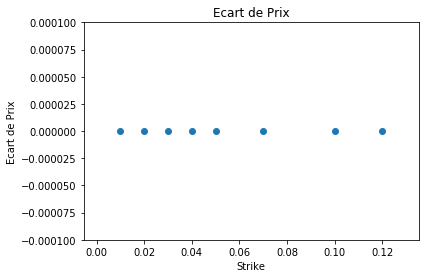

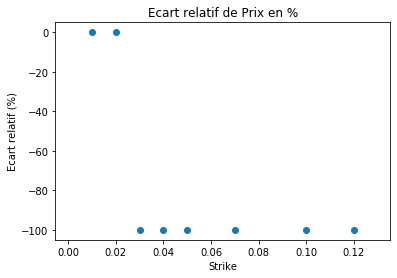

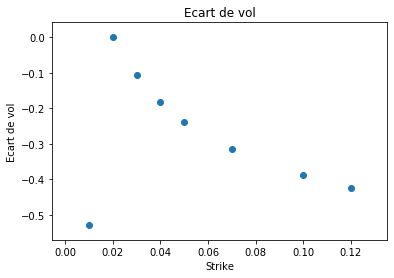

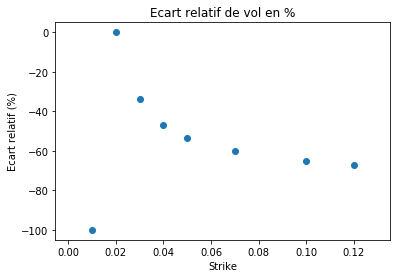

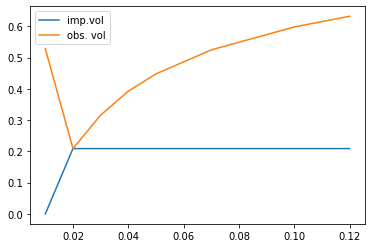

In [13]:
# comparaison des parametres calculés sur les prix et ceux calculés sur la vol. implicite
T0 = 1/12
maturities = np.arange(T0,maturity_grid[-1]+1/12,1/12)
bonds = [np.exp(-r*m) for m in maturities]
A0 = A(0,0,0,maturities,bonds,1,chi)
S0 = S(0,0,0,maturities,bonds,1,chi)
lmbdas = [0]
b_vals = [0]
diff_price1 = [log_displaced(S0,A0,T0,strikes[m],data[0][0],data[0][1]) - Price_BS(S0,A0,T0,strikes[m],IV[0][m]) for m in range(len(strikes))]
diff_vol1 = [(biss_python(log_displaced(S0,A0,T0,strikes[m],data[0][0],data[0][1]), bonds, strikes[m], maturities) - IV[0][m]) for m in range(len(strikes))]

plt.scatter(strikes,diff_price1)
plt.ylim([-0.0001, 0.0001])
plt.xlabel("Strike")
plt.ylabel("Ecart de Prix")
plt.title("Ecart de Prix")
plt.show()

ecart_relatif = [100*(log_displaced(S0,A0,T0,strikes[m],data[0][0],data[0][1]) - Price_BS(S0,A0,T0,strikes[m],IV[0][m]))/Price_BS(S0,A0,T0,strikes[m],IV[0][m]) for m in range(len(strikes))]
plt.scatter(strikes,ecart_relatif)
plt.xlabel("Strike")
plt.ylabel("Ecart relatif (%)")
plt.title("Ecart relatif de Prix en %")
plt.show()

plt.scatter(strikes,diff_vol1)
plt.xlabel("Strike")
plt.ylabel("Ecart de vol")
plt.title("Ecart de vol")
plt.show()

ecart_relatif1 = [100*(biss_python(log_displaced(S0,A0,T0,strikes[m],data[0][0],data[0][1]), bonds, strikes[m], maturities) - IV[0][m])/ IV[0][m] for m in range(len(strikes))]
plt.scatter(strikes,ecart_relatif1)
plt.xlabel("Strike")
plt.ylabel("Ecart relatif (%)")
plt.title("Ecart relatif de vol en %")
plt.show()

v= [biss_python(log_displaced(S0,A0,T0,strikes[m],data[0][0],data[0][1]), bonds, strikes[m], maturities) for m in range(len(strikes))]
u = IV[0]
plt.plot(strikes,v,label= 'imp.vol')
plt.plot(strikes,u,label='obs. vol')
plt.legend()
plt.show()

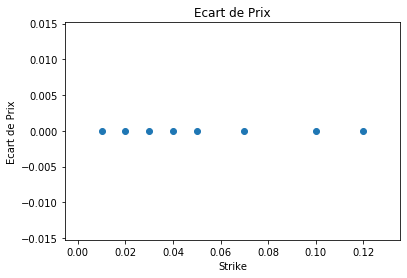

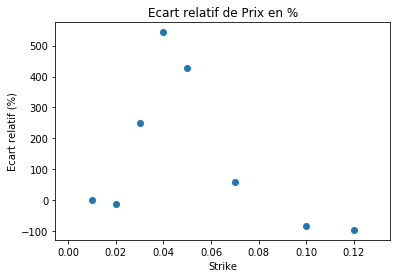

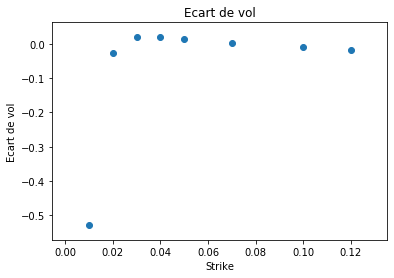

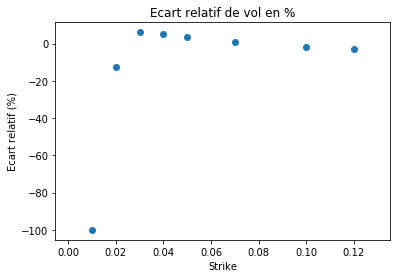

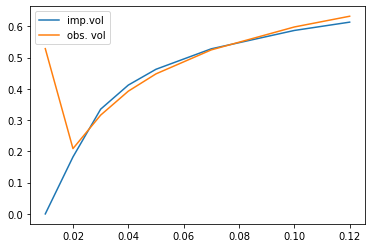

In [14]:
diff_price2 = [log_displaced(S0,A0,T0,strikes[m],data2[0][0],data2[0][1]) - Price_BS(S0,A0,T0,strikes[m],IV[0][m]) for m in range(len(strikes))]
diff_vol2 = [(biss_python(log_displaced(S0,A0,T0,strikes[m],data2[0][0],data2[0][1]), bonds, strikes[m], maturities) - IV[0][m]) for m in range(len(strikes))]

plt.scatter(strikes,diff_price2)
#plt.ylim([-0.001, 0.001])
plt.xlabel("Strike")
plt.ylabel("Ecart de Prix")
plt.title("Ecart de Prix")
plt.show()

ecart_relatif2 = [100*(log_displaced(S0,A0,T0,strikes[m],data2[0][0],data2[0][1]) - Price_BS(S0,A0,T0,strikes[m],IV[0][m]))/Price_BS(S0,A0,T0,strikes[m],IV[0][m]) for m in range(len(strikes))]
plt.scatter(strikes,ecart_relatif2)
plt.xlabel("Strike")
plt.ylabel("Ecart relatif (%)")
plt.title("Ecart relatif de Prix en %")
plt.show()

plt.scatter(strikes,diff_vol2)
plt.xlabel("Strike")
plt.ylabel("Ecart de vol")
plt.title("Ecart de vol")
plt.show()

ecart_relatif3 = [100*(biss_python(log_displaced(S0,A0,T0,strikes[m],data2[0][0],data2[0][1]), bonds, strikes[m], maturities) - IV[0][m])/ IV[0][m] for m in range(len(strikes))]
plt.scatter(strikes,ecart_relatif3)
plt.xlabel("Strike")
plt.ylabel("Ecart relatif (%)")
plt.title("Ecart relatif de vol en %")
plt.show()

v= [biss_python(log_displaced(S0,A0,T0,strikes[m],data2[0][0],data2[0][1]), bonds, strikes[m], maturities) for m in range(len(strikes))]
u = IV[0]
plt.plot(strikes,v,label= 'imp.vol')
plt.plot(strikes,u,label='obs. vol')
plt.legend()
plt.show()

## Implied volatility curve fitting

### Fitting on prices

(lambda,b)= [0.20000695 1.        ]
Diff array [1.58038896e-008 4.18196049e-019 1.33942436e-039 6.37998379e-063
 2.35581443e-110 9.69530216e-177 4.47407019e-217]


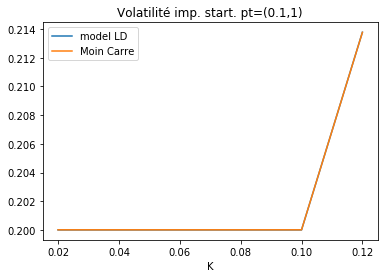

(lambda,b)= [0.19987177 1.00701703]
Diff array [-2.93882334e-007  7.34901013e-018  5.53650346e-038  4.08899324e-061
  2.92112344e-108  2.95067806e-174  2.46087749e-214]


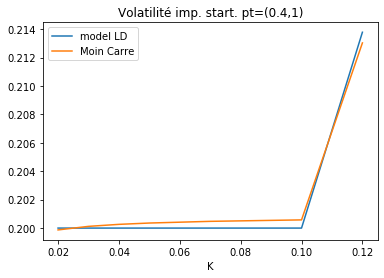

(lambda,b)= [0.2001424  1.35476262]
Diff array [2.03651335e-007 4.32900690e-015 6.56696878e-032 1.12640533e-049
 1.06615023e-083 7.97718828e-129 2.14789125e-155]


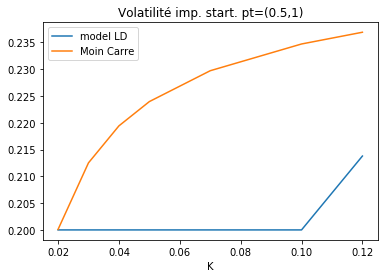

In [14]:
T0 = 1/12
maturities = np.arange(T0,T0+1+1/12,1/12)
bonds = [np.exp(-r*m) for m in maturities]
A0 = A(0,0,0,maturities,bonds,1,chi)
S0 = S(0,0,0,maturities,bonds,1,chi)
Prices = [log_displaced(S0,A0,T0,k,0.2,1) for k in strikes]
fun = lambda x: np.array([(log_displaced(S0,A0,T0,strikes[m],x[0],x[1]) - Prices[m]) for m in range(1,len(strikes))])
for l0 in [0.1,0.4,0.5]:
    x_0 = np.array([l0,1])
    opti = opt.least_squares(fun,x_0, bounds=([-np.inf,0], [np.inf,11]))
    opt_param = opti.x
    d = opti.fun
    print("(lambda,b)=",opt_param)
    print("Diff array",d)

    plt.plot(strikes[1:],[biss_python(Prices[m], bonds, strikes[m], maturities) for m in range(1,len(strikes))],label='model LD')
    plt.plot(strikes[1:],[biss_python(log_displaced(S0,A0,T0,k,opt_param[0],opt_param[1]), bonds, k, maturities) for k in strikes[1:]],label='Moin Carre')
    plt.legend()
    plt.title("Volatilité imp. start. pt=(" + str(l0)+",1)")
    plt.xlabel("K")
    plt.show()

(lambda,b)= [0.20000695 1.        ]
Diff array [1.58038896e-008 4.18196049e-019 1.33942436e-039 6.37998379e-063
 2.35581443e-110 9.69530216e-177 4.47407019e-217]


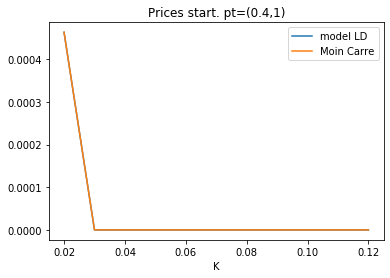

In [70]:
x_0 = np.array([0.1,1])
opti = opt.least_squares(fun,x_0, bounds=([-np.inf,0], [np.inf,11]))
opt_param = opti.x
d = opti.fun
print("(lambda,b)=",opt_param)
print("Diff array",d)

plt.plot(strikes[1:],Prices[1:],label='model LD')
plt.plot(strikes[1:],[log_displaced(S0,A0,T0,k,opt_param[0],opt_param[1]) for k in strikes[1:]],label='Moin Carre')
plt.legend()
plt.title("Prices start. pt=(0.4,1)")
plt.xlabel("K")
plt.show()

### Fitting on IV

(lambda,b)= [0.20000001 0.99999979]
Diff array [ 0.00000000e+00  1.39357326e-08  6.60065780e-09  2.44654075e-09
 -2.97859515e-10 -3.78804543e-09 -6.80074663e-09  9.91121851e-09]


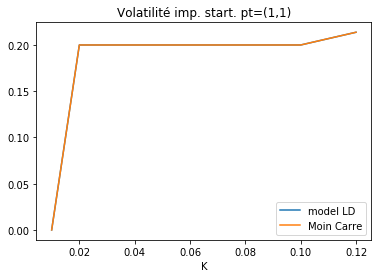

In [71]:
fun2 = lambda x: np.array([(biss_python(log_displaced(S0,A0,T0,strikes[m],x[0],x[1]),bonds,strikes[m],maturities) - biss_python(Prices[m], bonds, strikes[m], maturities)) for m in range(len(strikes))])
x_0 = np.array([0.5,1.5])
opti = opt.least_squares(fun2,x_0, bounds=([-np.inf,0], [np.inf,11]))
opt_param = opti.x
d = opti.fun
print("(lambda,b)=",opt_param)
print("Diff array",d)

plt.plot(strikes,[biss_python(Prices[m], bonds, strikes[m], maturities) for m in range(len(strikes))],label='model LD')
plt.plot(strikes,[biss_python(log_displaced(S0,A0,T0,k,opt_param[0],opt_param[1]), bonds, k, maturities) for k in strikes],label='Moin Carre')
plt.legend()
plt.title("Volatilité imp. start. pt=(1,1)")
plt.xlabel("K")
plt.show()

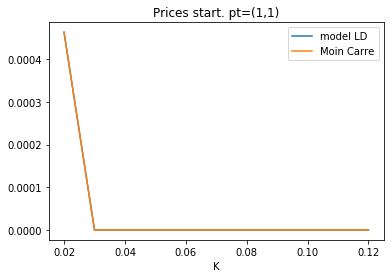

In [72]:
plt.plot(strikes[1:],Prices[1:],label='model LD')
plt.plot(strikes[1:],[log_displaced(S0,A0,T0,k,opt_param[0],opt_param[1]) for k in strikes[1:]],label='Moin Carre')
plt.legend()
plt.title("Prices start. pt=(1,1)")
plt.xlabel("K")
plt.show()

**Conclusion**: Better construct the data set with least squares method on Implied volatility because it seems to be less dependant on the starting point.

---

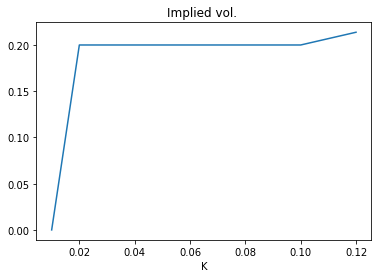

Strike: 0.01
Difference with the limit: -1.734723475976807e-18
0.009892410509646498
Strike: 0.02
Difference with the limit: 0.0004468833365562168
0.00046335238718965555
Strike: 0.03
Difference with the limit: 2.312457509341635e-16
2.312457509341635e-16
Strike: 0.04
Difference with the limit: 2.6206379779662484e-37
2.6206379779662484e-37
Strike: 0.05
Difference with the limit: 7.187244860381949e-61
7.187244860381949e-61
Strike: 0.07
Difference with the limit: 1.4213697129474589e-108
1.4213697129474589e-108
Strike: 0.1
Difference with the limit: 3.5330566627241844e-175
3.5330566627241844e-175
Strike: 0.12
Difference with the limit: 1.3120402316820564e-215
1.3120402316820564e-215


In [73]:
T0 = 1/12
maturities = np.arange(T0,1+1/12+1/12,1/12)
bonds = [np.exp(-r*m) for m in maturities]
A0 = A(0,0,0,maturities,bonds,1,chi)
S0 = S(0,0,0,maturities,bonds,1,chi)
strikes = [0.01,0.02,0.03,0.04,0.05,0.07,0.1,0.12]
curve = [biss_python(log_displaced(S0,A0,T0,k,0.2,1), bonds, k, maturities) for k in strikes]
plt.plot(strikes,curve,label='IV')
plt.xlabel("K")
plt.title("Implied vol. ")
plt.show()
for k in strikes:
    print("Strike:",k)
    p = log_displaced(S0,A0,T0,k,0.2,1)
    print("Difference with the limit:",p - A0 * max(0,S0-k))
    print(p)

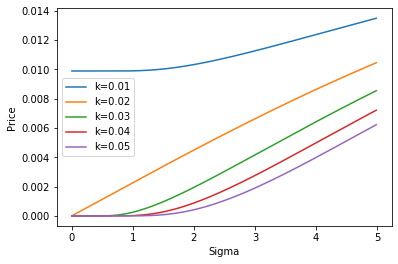

In [26]:
sigma_val = np.arange(0,5,0.01)
for k in strikes[0:5]:
    pric = [Price_BS(S0,A0,T0,k,s) for s in sigma_val]
    plt.plot(sigma_val,pric,label="k=" + str(k))
plt.legend()
plt.ylabel("Price")
plt.xlabel("Sigma")
plt.show()

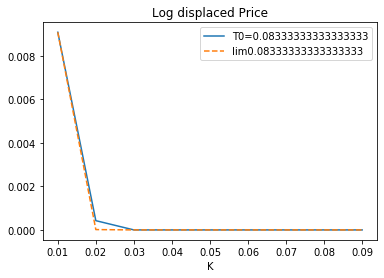

In [19]:
strikes = np.arange(0.01,0.1,0.01)
T0s = [0,0.5,1,2]
colors=['r','black','pink','purple','cyan']
i=0
for t in [1/12]:
    maturities = np.arange(t,t+1,1/12)
    T0 = maturities[0]
    bonds = [np.exp(-r*m) for m in maturities]
    A0 = A(0,0,0,maturities,bonds,1,chi)
    S0 = S(0,0,0,maturities,bonds,1,chi)
    limit_l = [A(0,0,0,maturities,bonds,1,chi)*max(0,S(0,0,0,maturities,bonds,1,chi)-k) for k in strikes]
    log_disp_prices_K = [log_displaced(S0,A0,T0,k,0.2,1) for k in strikes]
    plt.plot(strikes,log_disp_prices_K,label="T0="+str(t))
    plt.plot(strikes,limit_l,linestyle='--',label="lim" + str(t))
    
    i +=1
    
plt.xlabel("K")
plt.title("Log displaced Price")
plt.legend()

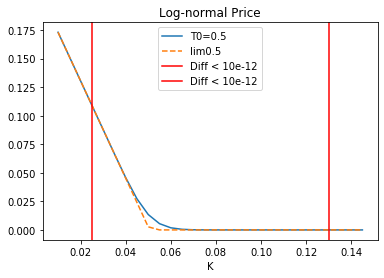

In [21]:
r=0.05
strikes = np.arange(0.01,0.15,0.005)
colors=['r','black','pink','purple','cyan']
i=0
for t in [0.5]:
    maturities = np.arange(t,t+5.5,0.5)
    T0 = maturities[0]
    bonds = [np.exp(-r*m) for m in maturities]
    A0 = A(0,0,0,maturities,bonds,1,chi)
    S0 = S(0,0,0,maturities,bonds,1,chi)
    limit_l = [A(0,0,0,maturities,bonds,1,chi)*max(0,S(0,0,0,maturities,bonds,1,chi)-k) for k in strikes]
    log_disp_prices_K = []
    gauche = 0
    droite = 0
    for k in strikes:
        p = log_displaced(S0,A0,T0,k,0.2,1)
        log_disp_prices_K.append(p)
            
    plt.plot(strikes,log_disp_prices_K,label="T0="+str(t))
    plt.plot(strikes,limit_l,linestyle='--',label="lim" + str(t))
    plt.axvline(strikes[3], 0, 1, label='Diff < 10e-12',color='r')
    plt.axvline(strikes[24], 0, 1, label='Diff < 10e-12',color='r')
    
    i +=1
    
plt.xlabel("K")
plt.title("Log-normal Price")
plt.legend()
plt.show()

----

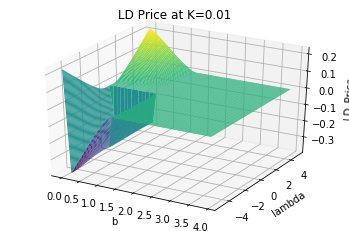

In [22]:
x_vals = np.arange(-5,5,0.1)
y_vals = np.arange(0,4,0.1)
X,Y = np.meshgrid(y_vals,x_vals)
Z = np.zeros((len(x_vals),len(y_vals)))
for i in range(len(x_vals)):
    for j in range(len(y_vals)):
        Z[i][j] = log_displaced(S0,A0,T0,strikes[0],x_vals[i],y_vals[j]) - log_displaced(S0,A0,T0,strikes[0],0.2,1)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('b')
ax.set_ylabel('lambda')
ax.set_zlabel('LD_Price')
plt.title("LD Price at K=0.01")
plt.show()

## 2.  $\bar{x}, \ \bar{y}$

In [14]:
#maturity_grid : (T0=0,...,TN) n-th swaption of the strip expires at Tn
#lmbdas : [lambda_1,...,lambda_n-1] known values of lambda 
# l : parameter for lambda_n
def y0(t,lmbdas,l,chi,maturity_grid):
    term_date = maturity_grid[-1]
    strip_size = np.size(maturity_grid)
    resu = 0
    i = 0
    while (t > maturity_grid[i]):
        Tn_m1 = maturity_grid[i]
        Tn = maturity_grid[i+1]
        mat = np.arange(Tn,term_date+0.5,0.5)
        S0 = S(0,0,0,mat,[np.exp(-r*m) for m in mat],1,chi)
        if (Tn >= t):
            resu += l**2 * S0**2 * (np.exp(-2*chi*(t-min(t,Tn))) - np.exp(-2*chi*(t-Tn_m1)))
        else:
            resu+= lmbdas[i]**2 * S0**2 * (np.exp(-2*chi*(t-Tn)) - np.exp(-2*chi*(t-Tn_m1)))
        i += 1 
    
    return resu/(2*chi)

In [15]:
y0(1.4,[0.5],1,chi,np.array([0,1,2,3]))

0.00013086334395114333

In [16]:
#First order approximation x0(t) 

def x0(t,maturities,bonds,lmbdas,l,chi,maturity_grid):
    S0 = S(0,0,0,maturities,bonds,1,chi)                
    g0 = G(t,maturities[0],chi)
    gN = G(t,maturities[-1],chi)
    y = y0(t,lmbdas,l,chi,maturity_grid)
    Swap_rate = lambda x: S(t,x,y,maturities,bonds,np.exp(-r*t),chi) - S0
    dS = lambda x: q(t,x,y,maturities,bonds,np.exp(-r*t),chi)
    return opt.newton(Swap_rate,0,dS)  #Newton method
    #return opt.newton(Swap_rate,0) # secant method 

In order to compute the second order approximation of $\mathbb{E}^A\big[x(t)\big]$, one needs to compute the value of $$\int_{0}^{t} \frac{\partial S}{\partial x}(s,0,0)^2 \sigma_r(s,0,0)^2 \ \mathrm{d}s = \sum_{n=1}^{N-1} \lambda_n^2 S_n(0)^2 \int_{T_{n-1}\land t}^{T_n \land t} \frac{\partial S}{\partial x}(s,0,0)^2 \ \mathrm{d}s$$

In [17]:
 #second derivative d2S/dx2
def dS2(t,x,y,maturities,bonds,ZC_t,chi):
    g0 = G(t,maturities[0],chi)
    gN = G(t,maturities[-1],chi)
    PT0 = (np.exp(-r*(maturities[0]-t))*np.exp(-1*g0*x-0.5*y*g0**2))
    PTN = (np.exp(-r*(maturities[-1]-t))*np.exp(-1*gN*x-0.5*y*gN**2))
    At = A(t,x,y,maturities,bonds,ZC_t,chi)
    Aprime = A(t,x,y,maturities,bonds,ZC_t,chi,1)
    Apprime = A(t,x,y,maturities,bonds,ZC_t,chi,2)
    S_rate = S(t,x,y,maturities,bonds,ZC_t,chi)
    return (g0**2 * PT0 - gN**2 * PTN - S_rate * Apprime)/At + 2*Aprime * (Aprime*S_rate + g0*PT0 - gN*PTN)/(At**2)

#second order approximation
def x_bar(t,maturities,bonds,ZC_t,lmbdas,l,chi,maturity_grid):
    y = y0(t,lmbdas,l,chi,maturity_grid)
    x = x0(t,maturities,bonds,lmbdas,l,chi,maturity_grid)
    #second derivative d2S/dx2
    d2S = dS2(t,x,y,maturities,bonds,ZC_t,chi)
    #second derivative d2X/ds2
    dX2 = -1*d2S/(q(t,x,y,maturities,bonds,ZC_t,chi)**3)
    #Compute Var
    term_date = maturity_grid[-1]
    strip_size = np.size(maturity_grid)
    i = 0
    Var = 0
    while (t > maturity_grid[i]) & (i < strip_size-2):
        Tn_m1 = maturity_grid[i]
        Tn = maturity_grid[i+1]
        mat = np.arange(Tn,term_date+0.5,0.5)
        S0 = S(0,0,0,mat,[np.exp(-r*m) for m in mat],1,chi)
        if (i == strip_size-3):
            Var += l**2 * S0**2 * integrate.quad(lambda s:  q(s,0,0,maturities,bonds,np.exp(-r*s),chi)**2,Tn_m1,min(t,Tn))[0]
        else:
            Var += lmbdas[i]**2 * S0**2 * integrate.quad(lambda s:  q(s,0,0,maturities,bonds,np.exp(-r*s),chi)**2,Tn_m1,min(t,Tn))[0]
        i += 1 
    return x + 0.5 * dX2 * Var

In [18]:
#test
t = 1.5
lmbdas = [0.5]
l = 1
maturity_grid = [0,1,2,3]
y = y0(t,lmbdas,l,chi,maturity_grid)
maturities = np.arange(t,t+5.5,0.5)
bonds = [np.exp(-r*m) for m in maturities]
S0 = S(0,0,0,maturities,bonds,1,chi)
x = x0(t,maturities,bonds,lmbdas,l,chi,maturity_grid)
print("x0= ",x,"S0= ",S0,"S(t,x0,y_bar)= ",S(t,x,y,maturities,bonds,np.exp(-r*t),chi))

x0=  0.0028868327579051646 S0=  0.020100334168336113 S(t,x0,y_bar)=  0.020100334155695003


In [19]:
x_bar(t,maturities,bonds,np.exp(-r*t),lmbdas,l,chi,maturity_grid)

0.0028368566576827473

## 3. $\bar{\lambda_{S_n}}, \bar{b_{S_n}}$

In [20]:
#function t -> lambda_S  in the pricing formula
def lS(t,x,y,lmbda,b,chi,maturities,bonds,ZC_t):
    S0 = S(0,0,0,maturities,bonds,1,chi)
    dS = q(t,x,y,maturities,bonds,ZC_t,chi)
    return (lmbda/S0) * dS * (S0 + b * x)

#function t -> b_S  in the pricing formula
def bS(t,x,y,b,chi,maturities,bonds,ZC_t):
    S0 = S(0,0,0,maturities,bonds,1,chi)
    dS = q(t,x,y,maturities,bonds,ZC_t,chi)
    d2S = dS2(t,x,y,maturities,bonds,ZC_t,chi)
    return (S0 * b) / ((S0 + b * x) * dS) + S0 * d2S/(dS**2)

In [21]:
# f: t -> int_0^t lambda_Sn (s)^2 ds

def f(t,maturities, bonds, maturity_grid,lmbdas, b_vals, l, b, chi):
    i = 0
    resu = 0
    while (maturity_grid[i] < t):
        #last integral with unknown parameters l,b
        if(maturity_grid[i+1] >= t):
            resu += integrate.quad(lambda u: lS(u,x_bar(u,maturities,bonds,np.exp(-r*u),lmbdas,l,chi,maturity_grid),y0(u,lmbdas,l,chi,maturity_grid),l,b,chi,maturities,bonds,np.exp(-r*u))**2 ,maturity_grid[i],t)[0]
        #integrals with known parameters lambda_i, b_i
        else:
            resu += integrate.quad(lambda u: lS(u,x_bar(u,maturities,bonds,np.exp(-r*u),lmbdas,l,chi,maturity_grid),y0(u,lmbdas,l,chi,maturity_grid),lmbdas[i],b_vals[i],chi,maturities,bonds,np.exp(-r*u))**2 ,maturity_grid[i],maturity_grid[i+1])[0]
        i += 1
    return resu


#maturities: payments dates of the underlying swap [Tn,...,TN]
def lambda_bar(maturities, bonds, maturity_grid,lmbdas, b_vals, l, b, chi):
    Tn = maturities[0]
    I = f(Tn,maturities, bonds, maturity_grid,lmbdas, b_vals, l, b, chi)
    return np.sqrt(I/Tn)

In [22]:
#
#index : index to use the value of lambda, b on the right interval
def phi(u,index,maturities,bonds,maturity_grid,lmbdas,b_vals,l,b,chi):
    y = y0(u,lmbdas,l,chi,maturity_grid)
    x = x_bar(u,maturities,bonds,np.exp(-r*u),lmbdas,l,chi,maturity_grid)
    if (index == -1):
        return bS(u,x,y,b,chi,maturities,bonds,np.exp(-r*u)) * lS(u,x,y,l,b,chi,maturities,bonds,np.exp(-r*u))**2 * f(u,maturities,bonds,maturity_grid,lmbdas,b_vals,l,b,chi)
    else:
        return bS(u,x,y,b_vals[index],chi,maturities,bonds,np.exp(-r*u)) * lS(u,x,y,lmbdas[index],b_vals[index],chi,maturities,bonds,np.exp(-r*u))**2 * f(u,maturities,bonds,maturity_grid,lmbdas,b_vals,l,b,chi)

def b_bar(maturities, bonds, maturity_grid, lmbdas, b_vals, l, b, chi):
    Tn = maturities[0]
    i = 0
    I = 0
    Denom = 0
    while(maturity_grid[i] < Tn):
        #Last integral with unknown parameters l,b
        if(maturity_grid[i+1] == Tn):
            I += integrate.quad(lambda u: phi(u,-1,maturities,bonds,maturity_grid,lmbdas,b_vals,l,b,chi),maturity_grid[i],Tn)[0]
            Denom += integrate.quad(lambda u: lS(u,x_bar(u,maturities,bonds,np.exp(-r*u),lmbdas,l,chi,maturity_grid),y0(u,lmbdas,l,chi,maturity_grid),l,b,chi,maturities,bonds,np.exp(-r*u))**2 * f(u,maturities,bonds,maturity_grid,lmbdas,b_vals,l,b,chi),maturity_grid[i],Tn)[0]
        
        #integrals with known parameters lambda_i,b_i
        else:
            I += integrate.quad(lambda u: phi(u,i,maturities,bonds,maturity_grid,lmbdas,b_vals,lmbdas[i],b_vals[i],chi),maturity_grid[i],maturity_grid[i+1])[0]
            Denom += integrate.quad(lambda u: lS(u,x_bar(u,maturities,bonds,np.exp(-r*u),lmbdas,l,chi,maturity_grid),y0(u,lmbdas,l,chi,maturity_grid),lmbdas[i],b_vals[i],chi,maturities,bonds,np.exp(-r*u))**2 * f(u,maturities,bonds,maturity_grid,lmbdas,b_vals,l,b,chi),maturity_grid[i],maturity_grid[i+1])[0]
        i += 1
    
    return I / Denom

## Tests

In [23]:
T0 = 1/12
maturity_grid = [0,1/12,1+1/12]
maturities = np.arange(T0,1 + 1/6, 1/12)
bonds = [np.exp(-r*m) for m in maturities]
lmbdas = [0]
b_vals = [0]
A0 = A(0,0,0,maturities,bonds,1,chi)
S0 = S(0,0,0,maturities,bonds,1,chi)
f(T0,maturities, bonds, maturity_grid,lmbdas, b_vals, 0.5, 1, chi)

0.007226524920582431

In [24]:
lambda_bar(maturities, bonds, maturity_grid,lmbdas, b_vals, 1, 1, chi)

0.5888042700104704

In [25]:
phi(T0,-1,maturities,bonds,maturity_grid,lmbdas,b_vals,0.5,0.1,chi)

0.00011417977490144632

In [26]:
b_bar(maturities, bonds, maturity_grid, lmbdas, b_vals, 1, 0.1, chi)

0.17305460953879312

In [64]:
#test calcul d'integrales
T0 = 1
maturity_grid = [0,1,6]
maturities = np.arange(T0,7,1)
bonds = [np.exp(-r*m) for m in maturities]
lmbdas = [0]
b_vals = [0]
quad_meth = f(T0,maturities, bonds, maturity_grid,lmbdas, b_vals, 0.5, 1, chi)
quad_250 = sum([lS(i/250,x_bar(i/250,maturities,bonds,np.exp(-r*i/250),lmbdas,0.5,chi,maturity_grid),y0(i/250,lmbdas,0.5,chi,maturity_grid),0.5,1,chi,maturities,bonds,np.exp(-r*i/250))**2 for i in range(1,251)])/250
quad_500 = sum([lS(i/500,x_bar(i/500,maturities,bonds,np.exp(-r*i/500),lmbdas,0.5,chi,maturity_grid),y0(i/500,lmbdas,0.5,chi,maturity_grid),0.5,1,chi,maturities,bonds,np.exp(-r*i/500))**2 for i in range(1,501)])/500
quad_1000 = sum([lS(i/1000,x_bar(i/1000,maturities,bonds,np.exp(-r*i/1000),lmbdas,0.5,chi,maturity_grid),y0(i/1000,lmbdas,0.5,chi,maturity_grid),0.5,1,chi,maturities,bonds,np.exp(-r*i/1000))**2 for i in range(1,1001)])/1000
print("Quad method Python:",quad_meth,"Quad. 250 steps:",quad_250,"Quad. 500 steps:",quad_500, "Quad. 1000 steps:",quad_1000)

Quad method Python: 0.005503784308185581 Quad. 250 steps: 0.005527026166269763 Quad. 500 steps: 0.005515397734835716 Quad. 1000 steps: 0.005509589145800115


In [70]:
quad_10000 = sum([lS(i/10000,x_bar(i/10000,maturities,bonds,np.exp(-r*i/10000),lmbdas,0.5,chi,maturity_grid),y0(i/10000,lmbdas,0.5,chi,maturity_grid),0.5,1,chi,maturities,bonds,np.exp(-r*i/10000))**2 for i in range(1,10001)])/10000
print(quad_10000)

0.005504364622897158


## 4. Calibration

### a) Simple method

The main difficulty in the calibration code is the method with which one computes the values of
$(\lambda_n,b_n)$ by making $\bar{\lambda_{S_n}},\bar{b_{S_n}}$ match with $\hat{\lambda_n},\hat{b_n}$. 
Indeed, on $]T_{n-1},T_n]$, $\bar{\lambda_{S_n}}$ and $\bar{b_{S_n}}$ depend on $\lambda_n$ and $b_n$, that's why one can't use a simple root finding. There exists a Newton algorithm in dimension 2, but it requires a Jacobian matrix and we haven't explicit formula for the derivatives with respect to $\lambda,b$ here.

One solution is to divide the problem in two parts. 
- On the one hand, one computes the value of $\lambda_n$ by approximating $\bar{x}(t) \approx 0$ on $]T_{n-1},T_n]$ in order to get an expression of $\bar{\lambda_{S_n}}$ independent of $b_n$.
$$\begin{array}{ll} 
\bar{\lambda_{S_n}} &= \Big( \frac{1}{T_n} \int_{0}^{T_n} \lambda_{S_n}(t)^2 \ \mathrm{d}t \Big)^{\frac{1}{2}} \\
&= \Big( \frac{1}{T_n} \big( \int_{0}^{T_{n-1}} \lambda_{S_n}(t)^2 \ \mathrm{d}t + \int_{T_{n-1}}^{T_n} \lambda_{S_n}(t, \lambda_n,b_n,\bar{x}(t))^2 \ \mathrm{d}t\big) \Big)^{\frac{1}{2}} \\
&\approx \Big( \frac{1}{T_n} \big( \int_{0}^{T_{n-1}} \lambda_{S_n}(t)^2 \ \mathrm{d}t + \int_{T_{n-1}}^{T_n} \lambda_{S_n}(t, \lambda_n,b_n,0)^2 \ \mathrm{d}t\big) \Big)^{\frac{1}{2}} \\
&= \big( Z_1 ((\lambda_i)_{i=1,n-1},(b_i)_{i=1,n-1}) + \zeta_1(\lambda_n) \big)^{\frac{1}{2}}
\end{array}$$

- On the other hand 
$$\begin{array}{ll} 
\bar{b_{S_n}} &= \int_{0}^{T_n} b_{S_n}(t) \ w_{S_n}(t) \ \mathrm{d}t \\
&= \int_{0}^{T_{n-1}} b_{S_n}(t) w_{S_n}(t) \ \mathrm{d}t + \int_{T_{n-1}}^{T_n} b_{S_n}(t) \ w_{S_n}(t,\lambda_n,b_n) \ \mathrm{d}t \\
&= Z_2 ((\lambda_i)_{i=1,n-1},(b_i)_{i=1,n-1}) + \zeta_2(\lambda_n,b_n)
\end{array}$$
And one solves this equation for $b_n$, using the computed value of $\lambda_n$ from last step.

In [27]:
# Calibration algorithm with naiv approach

def calib(data, maturity_grid, delta):
    N = len(maturity_grid) - 1
    term_date = maturity_grid[-1]
    lmbdas = np.zeros(N-1)
    b_vals = np.zeros(N-1)
    for n in range(0,N-1):
        maturities = np.arange(maturity_grid[n+1],term_date + delta, delta)
        bonds = [np.exp(-r*m) for m in maturities]
        
        #Root finding for lambda_n
        lambda_obs = data[n][0]
        lambda_n = opt.bisect(lambda l: lambda_bar(maturities, bonds, maturity_grid,lmbdas, b_vals, l, 0, chi) - lambda_obs,0,10)
        lmbdas[n] = lambda_n
        
        #Root finding for b_n
        b_obs = data[n][1]
        b_n = opt.bisect(lambda b: b_bar(maturities, bonds, maturity_grid, lmbdas, b_vals, lambda_n, b, chi) - b_obs, 0 , 10)
        b_vals[n] = b_n
    return lmbdas,b_vals

### Calibration with data fitted on Prices

In [31]:
#test calibration
maturity_grid = [0,1/12,1+1/12]
strikes = [0.01,0.02,0.03,0.04,0.05,0.07,0.1,0.12]
IV = [[0.528341118,0.248871904,0.315791907,0.392419764,0.447727552,0.524478308,0.59765607,0.631982811]]
delta = 1/12
data = data_set(maturity_grid,strikes,IV,chi,delta,0.208871904)
calib_param = calib(data, maturity_grid, delta)
print("(lambda_1,b_1) =",calib_param)

(lambda_1,b_1) = (array([0.40886754]), array([0.61506426]))


[-1.2481475679393395e-09, -2.016785058386178e-05, -2.2314572573491027e-09, -2.632649917050416e-13, -4.187083086441031e-16, -4.8079361321683474e-20, -4.8454030684463324e-24, -4.5375142126633257e-26]


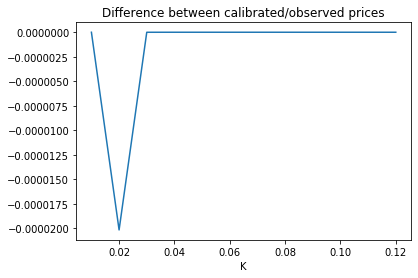

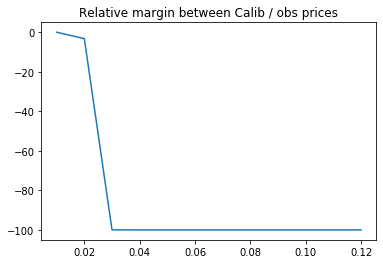

In [42]:
# Plot of the price difference between observed prices and thus with calibrated parameters

calib_b_bar = b_bar(maturities, bonds, maturity_grid, [0], [0], calib_param[0][0], calib_param[1][0], chi)
calib_lambda_bar = lambda_bar(maturities, bonds, maturity_grid,[0], [0], calib_param[0][0], calib_param[1][0], chi)
d = [log_displaced(S0,A0,T0,strikes[m],calib_lambda_bar,calib_b_bar) - Price_BS(S0,A0,T0,strikes[m],IV[0][m]) for m in range(len(strikes))]
plt.plot(strikes,d)
plt.title("Difference between calibrated/observed prices")
plt.xlabel("K")
print(d)
plt.show()
d2 = [100*d[m]/Price_BS(S0,A0,T0,strikes[m],IV[0][m]) for m in range(len(strikes))]
plt.plot(strikes,d2)
plt.title("Relative margin between Calib / obs prices")
plt.show()

### Calibration with data fitted on implied volatility

In [43]:
data2 = data_set_bis(maturity_grid,strikes,IV,chi,delta,[0.208871904])
calib_param = calib(data2, maturity_grid, delta)
print("(lambda_1,b_1) =",calib_param)

(lambda_1,b_1) = (array([0.34448076]), array([3.34053436]))


[-1.2481475714087864e-09, -0.00011466226363950646, 1.0903655526055525e-08, 2.1126167734490094e-12, 1.888083148712934e-15, -5.274603086103055e-21, -4.632123735812821e-24, -4.5066321209403197e-26]


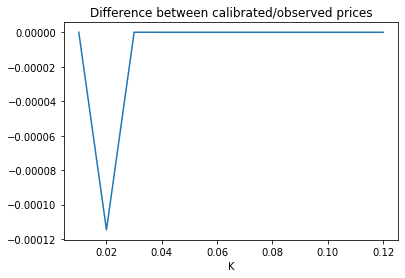

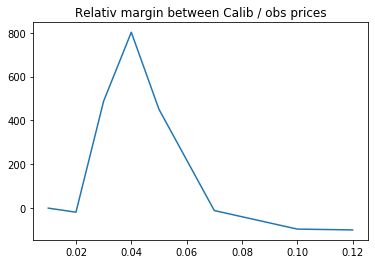

In [44]:
# Plot of the price difference between observed prices and thus with calibrated parameters

calib_b_bar = b_bar(maturities, bonds, maturity_grid, [0], [0], calib_param[0][0], calib_param[1][0], chi)
calib_lambda_bar = lambda_bar(maturities, bonds, maturity_grid,[0], [0], calib_param[0][0], calib_param[1][0], chi)
d = [log_displaced(S0,A0,T0,strikes[m],calib_lambda_bar,calib_b_bar) - Price_BS(S0,A0,T0,strikes[m],IV[0][m]) for m in range(len(strikes))]
plt.plot(strikes,d)
plt.title("Difference between calibrated/observed prices")
plt.xlabel("K")
print(d)
plt.show()
d2 = [100*d[m]/Price_BS(S0,A0,T0,strikes[m],IV[0][m]) for m in range(len(strikes))]
plt.plot(strikes,d2)
plt.title("Relativ margin between Calib / obs prices")
plt.show()

### Calibration with data fitted on prices' relative margin

In [65]:
def data_set_tiers(maturity_grid,strikes,IV,chi,delta,iv_atm):
    term_date = maturity_grid[-1]
    res = np.zeros((len(maturity_grid)-2,2))
    for i in range(1,len(maturity_grid)-1):
        T0 = maturity_grid[i]
        maturities = np.arange(T0,term_date + delta,delta)
        bonds = [np.exp(-r*m) for m in maturities]
        A0 = A(0,0,0,maturities,bonds,1,chi)
        S0 = S(0,0,0,maturities,bonds,1,chi)
        fun = lambda x: np.array([(log_displaced(S0,A0,T0,strikes[m],x[0],x[1]) - Price_BS(S0,A0,T0,strikes[m],IV[i-1][m]))/(Price_BS(S0,A0,T0,strikes[m],IV[i-1][m])) for m in range(len(strikes))])
        x_0 = np.array([iv_atm,1])
        opt_param = opt.least_squares(fun,x_0, bounds=([-np.inf,0], [np.inf,10])).x
        res[i-1] = opt_param
    return res

In [66]:
data3 = data_set_tiers(maturity_grid,strikes,IV,chi,delta,0.208871904)
calib_param = calib(data3, maturity_grid, delta)
print("(lambda_1,b_1) =",calib_param)

(lambda_1,b_1) = (array([0.22543661]), array([6.24178456]))


[-1.2481475714087864e-09, -0.0002868124542029297, -1.1442945149157934e-09, 1.94929181169631e-16, 9.405797332737365e-17, -3.425231575575314e-21, -2.9639535359504324e-24, -3.5769360766805963e-26]


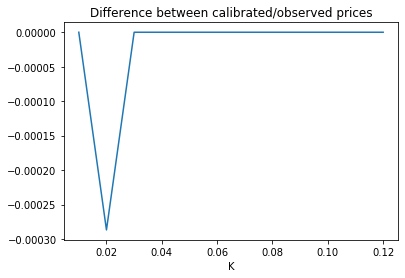

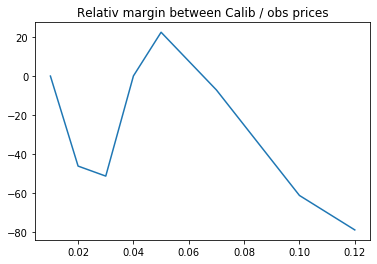

In [67]:
# Plot of the price difference between observed prices and thus with calibrated parameters

calib_b_bar = b_bar(maturities, bonds, maturity_grid, [0], [0], calib_param[0][0], calib_param[1][0], chi)
calib_lambda_bar = lambda_bar(maturities, bonds, maturity_grid,[0], [0], calib_param[0][0], calib_param[1][0], chi)
d = [log_displaced(S0,A0,T0,strikes[m],calib_lambda_bar,calib_b_bar) - Price_BS(S0,A0,T0,strikes[m],IV[0][m]) for m in range(len(strikes))]
plt.plot(strikes,d)
plt.title("Difference between calibrated/observed prices")
plt.xlabel("K")
print(d)
plt.show()
d2 = [100*d[m]/Price_BS(S0,A0,T0,strikes[m],IV[0][m]) for m in range(len(strikes))]
plt.plot(strikes,d2)
plt.title("Relativ margin between Calib / obs prices")
plt.show()

### b) Calibration par minimisation sur $\bar{\lambda},\bar{b}$

Ici l'objectif de la fonction de calibration est de trouver une valeur pour $(\lambda_n,b_n)$ à chaque étape $n$ en minimisant la fonction $$(\lambda_n,b_n) \rightarrow \lVert \big(\bar{\lambda}(\lambda_n,b_n), \bar{b}(\lambda_n,b_n) \big) - \big(\hat{\lambda},\hat{b} \big) \rVert ^2 = \big(\bar{\lambda}(\lambda_n,b_n) - \hat{\lambda} \big)^2 + \big(\bar{b}(\lambda_n,b_n) - \hat{b} \big)^2$$

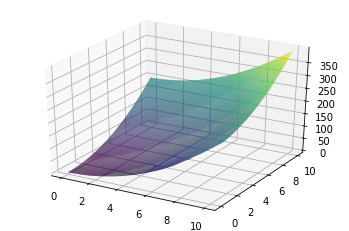

array([2.05649609e-05, 2.46854500e-05])

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 43
         Function evaluations: 81


In [68]:
# test function minimization with 2 variables

fun = lambda x: (x[0] - x[1])**2 + (x[0] + x[1])**2

x_vals = np.arange(0,10,0.01)
X,Y = np.meshgrid(x_vals,x_vals)
Z = np.zeros((len(x_vals),len(x_vals)))
for i in range(len(x_vals)):
    for j in range(len(x_vals)):
        Z[i][j] = fun([x_vals[i],x_vals[j]])

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
plt.show()

opt.fmin(fun,[1,0])

In [46]:
def calib2(data, maturity_grid, delta, exec_time=False):
    t1 = time()
    N = len(maturity_grid) - 1
    term_date = maturity_grid[-1]
    lmbdas = np.zeros(N-1)
    b_vals = np.zeros(N-1)
    for n in range(0,N-1):
        maturities = np.arange(maturity_grid[n+1],term_date + delta, delta)
        bonds = [np.exp(-r*m) for m in maturities]
        lambda_obs = data[n][0]
        b_obs = data[n][1]
        
        # optimization step
        
        fun = lambda x: (lambda_bar(maturities, bonds, maturity_grid,lmbdas, b_vals, x[0], x[1], chi) - lambda_obs)**2 + (b_bar(maturities, bonds, maturity_grid, lmbdas, b_vals, x[0], x[1], chi) - b_obs)**2
        opt_param = opt.fmin(fun,[1,1])
        lmbdas[n] = opt_param[0]
        b_vals[n] = opt_param[1]
    
    t2 = time()
    if(exec_time):
        print("Exec. time:",t2-t1, "sec")
    return lmbdas,b_vals

In [70]:
#Calibration with Data fitted on prices

calib_param2 = calib2(data,maturity_grid,delta)
print(calib_param2)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 35
         Function evaluations: 70
(array([0.40852601]), array([0.61505049]))


[-1.248147569674063e-09, -2.066267821090352e-05, -2.231489430913526e-09, -2.632649917050421e-13, -4.187083086441031e-16, -4.8079361321683474e-20, -4.8454030684463324e-24, -4.5375142126633257e-26]


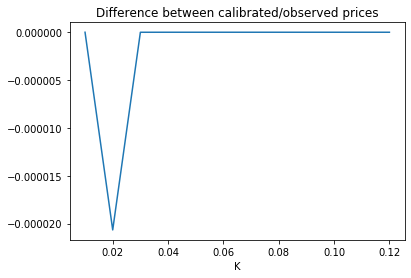

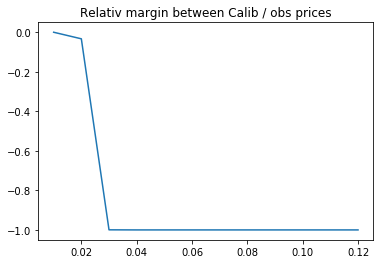

In [71]:
calib_b_bar = b_bar(maturities, bonds, maturity_grid, [0], [0], calib_param2[0][0], calib_param2[1][0], chi)
calib_lambda_bar = lambda_bar(maturities, bonds, maturity_grid,[0], [0], calib_param2[0][0], calib_param2[1][0], chi)
d = [log_displaced(S0,A0,T0,strikes[m],calib_lambda_bar,calib_b_bar) - Price_BS(S0,A0,T0,strikes[m],IV[0][m]) for m in range(len(strikes))]
plt.plot(strikes,d)
plt.title("Difference between calibrated/observed prices")
plt.xlabel("K")
print(d)
plt.show()
d2 = [d[m]/Price_BS(S0,A0,T0,strikes[m],IV[0][m]) for m in range(len(strikes))]
plt.plot(strikes,d2)
plt.title("Relativ margin between Calib / obs prices")
plt.show()

In [72]:
calib_param2 = calib2(data2,maturity_grid,delta)
print(calib_param2)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 53
         Function evaluations: 100
(array([-0.34294043]), array([3.34052631]))


[-1.2481475714087864e-09, -0.000116869546125307, 9.816128594677746e-09, 1.7585192901595885e-12, 1.4274818579357835e-15, -1.6992123576779254e-20, -4.706561232264098e-24, -4.518557101483728e-26]


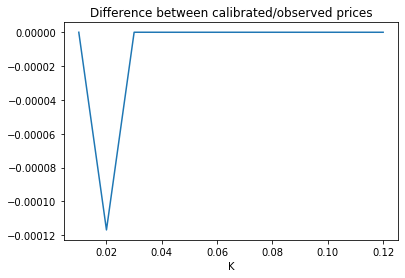

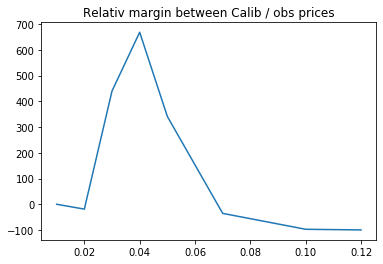

In [73]:
calib_b_bar = b_bar(maturities, bonds, maturity_grid, [0], [0], calib_param2[0][0], calib_param2[1][0], chi)
calib_lambda_bar = lambda_bar(maturities, bonds, maturity_grid,[0], [0], calib_param2[0][0], calib_param2[1][0], chi)
d = [log_displaced(S0,A0,T0,strikes[m],calib_lambda_bar,calib_b_bar) - Price_BS(S0,A0,T0,strikes[m],IV[0][m]) for m in range(len(strikes))]
plt.plot(strikes,d)
plt.title("Difference between calibrated/observed prices")
plt.xlabel("K")
print(d)
plt.show()
d2 = [100*d[m]/Price_BS(S0,A0,T0,strikes[m],IV[0][m]) for m in range(len(strikes))]
plt.plot(strikes,d2)
plt.title("Relativ margin between Calib / obs prices")
plt.show()

### c) Calibration sur $\bar{b}$ uniquement

**1.Relation entre $\lambda$ et $b$ pour tous les strikes**

On veut $$V_0^{LD} \big(\bar{\lambda}, \bar{b}, S_0, K \big) = V_0^{BS} \big(S_0,K,\hat{\sigma} \big)$$

Si on pose $\psi_{b,S,K} : \lambda \rightarrow V_0^{LD} \big(\lambda, b, S, K \big)$, supposée continue et inversible.

Alors on a: $$\begin{array}{ll} 
\bar{\lambda} &= \psi_{\bar{b},S_0,K}^{-1} \Big(V_0^{BS} \big(S_0,K,\hat{\sigma} \big) \Big) \\
&= f \Big(\bar{b},S_0,K, \hat{\sigma} \Big) \end{array}$$


La nième étape de calibration consistera donc à minimiser la fonction $$(\lambda_n,b_n) \rightarrow \Big( \bar{b}(\lambda_n,b_n) - \hat{b}_n \Big)^2$$

La base de donnée à partir de laquelle on va calibrer le modèle deviendra donc $(\hat{b}_i)_{i=1,N}$.

Lorsque l'on construit cette base de donnée, on veut dans le cas idéal un couple $(\lambda,b)$ tel que: $$V_0^{LD}(S_0,K,\lambda,b) = V_0^{BS}(S_0,K,\hat{\sigma})$$

On va noter $\phi_{S,K,b} : \lambda \rightarrow V_0^{LD}(S,K,\lambda,b)$

Donc $$\begin{array}{ll}
\phi_{S_0,K,b} (\lambda) &= V_0^{BS}(S_0,K,\hat{\sigma}) \\
\implies \lambda &= \phi_{S_0,K,b}^{-1} \Big(V_0^{BS}(S_0,K,\hat{\sigma}) \Big) \\
&= \tilde{f} (b, S_0, K, \hat{\sigma})
\end{array}$$

On se propose donc d'appliquer la méthode des moindres carrées sur les quantités suivantes:
$$\forall K_i, \quad V_0^{LD}\big(S_0,K_i,\tilde{f}(b,S_0, K_i,\hat{\sigma}),b\big) - V_0^{BS}(S_0,K_i,\hat{\sigma})$$

Dans le code, on calcule $\tilde{f}(b,S_0, K_i,\hat{\sigma})$ de la manière suivante:
$$\tilde{f}(b,S_0, K_i,\hat{\sigma}) = bisect \Big( x \rightarrow \sigma_{Imp} \big(V_0^{LD}(S_0,K_i,x,b) \big) - \hat{\sigma} \Big)$$

Cela conduit à des calculs numériques et des erreurs supplémentaires.

**2. Relation entre $\lambda$ et $b$ à la monnaie** 

Il est possible de trouver une relation explicite entre $\lambda$ et $b$ qui est exacte à la monnaie mais pas pour tous les strikes. 

Soit $T_0$ fixée. On suppose $S_0 = K$ et on note $\hat{\sigma}$ la volatilité implicite à la monnaie.

D'une part, $$\begin{array}{ll}
V_0^{BS}(S_0,S_0,T_0,\hat{\sigma}) &= A(0) S_0 \Big(\Phi \big( \frac{\hat{\sigma}\sqrt{T_0}}{2}\big) - \Phi \big( \frac{- \hat{\sigma}\sqrt{T_0}}{2}\big) \Big) \\
&= A(0) S_0 \Big( 2 \Phi \big( \frac{\hat{\sigma}\sqrt{T_0}}{2}\big) - 1 \Big)
\end{array}$$

D'autre part, $$\begin{array}{ll}
V_0^{LD}(S_0,S_0,T_0,\lambda,b) &= A(0) \frac{S_0}{b} \Big(\Phi \big( \frac{\lambda b \sqrt{T_0}}{2}\big) - \Phi \big( \frac{- \lambda b \sqrt{T_0}}{2}\big) \Big) \\
&= A(0) \frac{S_0}{b} \Big( 2 \Phi \big( \frac{\lambda b \sqrt{T_0}}{2}\big) - 1 \Big)
\end{array}$$

Donc $$\begin{array}{ll}
V_0^{LD}(S_0,S_0,\lambda,b) &= V_0^{BS}(S_0,K,\hat{\sigma}) \\
\iff \frac{1}{b} \Big( 2 \Phi \big( \frac{\lambda b \sqrt{T_0}}{2}\big) - 1 \Big) &= \Big( 2 \Phi \big( \frac{\hat{\sigma}\sqrt{T_0}}{2}\big) - 1 \Big) \\
\iff \Phi \big( \frac{\lambda b \sqrt{T_0}}{2}\big) &= b \Phi \big( \frac{\hat{\sigma}\sqrt{T_0}}{2}\big) + \frac{1}{2} (1-b)
\end{array}$$

Et on a finalement $$\boxed{\lambda = \frac{2}{b \sqrt{T_0}} \Phi^{-1} \Big(b \Phi \big( \frac{\hat{\sigma}\sqrt{T_0}}{2}\big) + \frac{1}{2} (1-b) \Big) = \psi(T_0,b,\hat{\sigma})}$$

On se propose alors de construire un data set $(\hat{b}_i)_i$ en appliquant la méthode des moindres carrés aux quantités suivantes $$\forall K_i, \quad \sigma_{imp} \Big( V_0^{LD} \Big(S_0,K_i,T_0, \psi \big(T_0,b,\hat{\sigma} \big),b \Big) \Big) - \hat{\sigma}(K_i)$$

Maintenant que les paramètres d'entrée sont disponibles, il reste à calibrer les paramètres de volatilité du modèle de Cheyette $(\lambda_n,b_n)_{n=1,N-1}$ de telle sorte que 
$$\forall n \in [|1,N-1|], \quad (\lambda_n,b_n) = argmin_{\lambda,b} \big(\bar{b}(\lambda,b) - \hat{b}_n \big)^2$$

Une fois la calibration achevée, il est possible d'évaluer les prix de swaption dans notre modèle à l'aide des paramètres obtenus. Pour un swaption qui expire à $T_n$, on doit calculer le premier paramètre $\bar{b}\big((\lambda_i,b_i)_{i=1,n}\big)$. Quant au second paramètre $\bar{\lambda}$, on le calcule grâce à la relation $$\bar{\lambda} = \psi \big(T_n, \hat{\sigma}_{ATM}, \bar{b}\big((\lambda_i,b_i)_{i=1,n}\big) \big)$$

In [29]:
#function b, sigma_imp_ATM -> lambda

def psi(T0,sigma_imp,b):
    return 2 / (b * np.sqrt(T0)) * stats.norm.ppf(b * stats.norm.cdf(0.5 * sigma_imp * np.sqrt(T0)) + 0.5 * (1-b))

# Construction of the data set on b only

def data_b(maturity_grid,strikes,IV,chi,delta,iv_atm):
    term_date = maturity_grid[-1]
    res = np.zeros((len(maturity_grid)-2,1))
    for i in range(1,len(maturity_grid)-1):
        T0 = maturity_grid[i]
        maturities = np.arange(T0,term_date + delta,delta)
        bonds = [np.exp(-r*m) for m in maturities]
        A0 = A(0,0,0,maturities,bonds,1,chi)
        S0 = S(0,0,0,maturities,bonds,1,chi)
        fun = lambda x: np.array([(biss_python(log_displaced(S0,A0,T0,strikes[m],psi(T0,iv_atm,x),x), bonds, strikes[m], maturities) - IV[i-1][m]) for m in range(len(strikes))])
        x_0 = np.array([iv_atm])
        opt_param = opt.least_squares(fun,x_0, bounds=([0], [25]),gtol=5e-16).x
        res[i-1] = opt_param
    return res

def calib3(data, maturity_grid, delta):
    N = len(maturity_grid) - 1
    term_date = maturity_grid[-1]
    lmbdas = np.zeros(N-1)
    b_vals = np.zeros(N-1)
    for n in range(0,N-1):
        maturities = np.arange(maturity_grid[n+1],term_date + delta, delta)
        bonds = [np.exp(-r*m) for m in maturities]
        b_obs = data[n][0]
        
        # optimization step
        
        fun = lambda x: (b_bar(maturities, bonds, maturity_grid, lmbdas, b_vals, x[0], x[1], chi) - b_obs)**2 
        opt_param = opt.fmin(fun,[1,1])
        lmbdas[n] = opt_param[0]
        b_vals[n] = opt_param[1]
        
    return lmbdas,b_vals

In [32]:
data_b_only = data_b(maturity_grid,strikes,IV,chi,delta,IV[0][1])
print("b_obs=",data_b_only)

b_obs= [[0.4144405]]


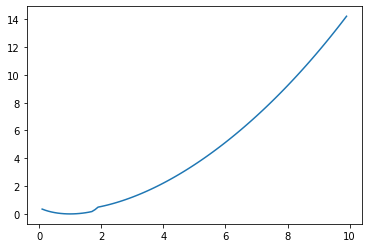

In [34]:
x_vals = np.arange(0.1,10,0.1)
y = [sum([(biss_python(log_displaced(S0,A0,T0,strikes[m],psi(T0,IV[0][m],x),x), bonds, strikes[m], maturities) - IV[0][m])**2 for m in range(len(strikes))]) for x in x_vals]
plt.plot(x_vals,y)

In [35]:
calib_param3 = calib3(data_b_only, maturity_grid, delta)
print("(lambda1,b1)=",calib_param3)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 69
         Function evaluations: 127
(lambda1,b1)= (array([1.12725317]), array([0.25293573]))


Absolute diff. [-1.2481475714087864e-09, 1.457894324135428e-07, -2.232486507094902e-09, -2.6326499170504765e-13, -4.187083086441031e-16, -4.8079361321683474e-20, -4.8454030684463324e-24, -4.5375142126633257e-26]


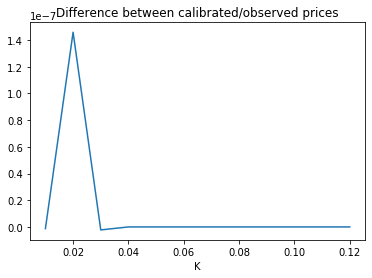

Relative diff. [-1.1656342621711716e-05, 0.023444123431274243, -99.99819222085962, -100.0, -100.0, -100.0, -100.0, -100.0]


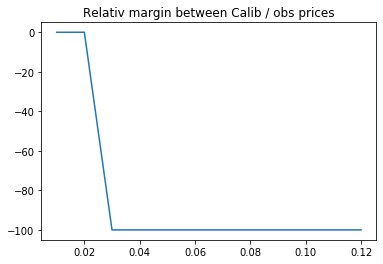

In [36]:
calib_b_bar = b_bar(maturities, bonds, maturity_grid, [0], [0], calib_param3[0][0], calib_param3[1][0], chi)
calib_lambda_bar = psi(T0,IV[0][1],calib_b_bar) # lambda bar = psi (b_bar) with ATM Implied vol.
d = [log_displaced(S0,A0,T0,strikes[m],calib_lambda_bar,calib_b_bar) - Price_BS(S0,A0,T0,strikes[m],IV[0][m]) for m in range(len(strikes))]
plt.plot(strikes,d)
plt.title("Difference between calibrated/observed prices")
plt.xlabel("K")
print("Absolute diff.",d)
plt.show()
d2 = [100*d[m]/Price_BS(S0,A0,T0,strikes[m],IV[0][m]) for m in range(len(strikes))]
plt.plot(strikes,d2)
plt.title("Relativ margin between Calib / obs prices")
print("Relative diff.",d2)
plt.show()

## Test sanitaire sur des prix log-normaux décalés

### Calibration sur $\bar{b}$

In [59]:
# Sanitary test on displaced log normal prices 
l = 0.5
b = 0.9

maturity_grid = [0,1,6]
T0 = 1
term_date = 6
delta = 1
maturities = np.arange(T0,term_date + delta,delta)
bonds = [np.exp(-r*m) for m in maturities]
S0 = S(0,0,0,maturities,bonds,1,chi)
A0 = A(0,0,0,maturities,bonds,1,chi)
strikes = [0.1*k*S0 for k in range(5,16)] # 50% to 150% of the strike ATM

# Data
IV = [[biss_python(log_displaced(S0,A0,T0,strikes[m],l,b), bonds, strikes[m], maturities) for m in range(len(strikes))]]
slope_atm = abs((IV[0][6] - IV[0][4])/0.2*S0)
data = data_b(maturity_grid,strikes,IV,chi,delta,IV[0][5])
print("starting pt. = ",IV[0][5],"b_obs=",data)

starting pt. =  0.5010039084265827 b_obs= [[0.9]]


In [38]:
# Calibration
calib_param = calib3(data, maturity_grid, delta)
print("(lambda_Pit.,b_Pit.)=",calib_param)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 43
         Function evaluations: 81
(lambda_Pit.,b_Pit.)= (array([1.16962589]), array([0.14103542]))


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1807: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= _b) & cond0


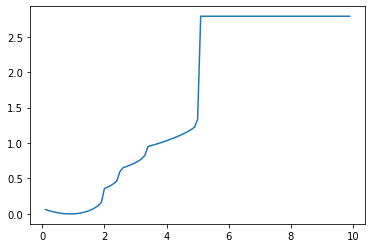

In [39]:
x_vals = np.arange(0.1,10,0.1)
y = [sum([(biss_python(log_displaced(S0,A0,T0,strikes[m],psi(T0,IV[0][5],x),x), bonds, strikes[m], maturities) - IV[0][m])**2 for m in range(len(strikes))]) for x in x_vals]
plt.plot(x_vals,y)

Lambda_bar, b_bar =  0.49999999786996324 0.8999997750011356
Absolute diff. [5.214754045246295e-10, 5.87477948232884e-10, 5.407396821976995e-10, 4.0218874758357614e-10, 2.0953478535590264e-10, 3.046868313205664e-14, -1.9798233885648386e-10, -3.670172776804037e-10, -4.989945921740624e-10, -5.926329565975053e-10, -6.508836629393056e-10]


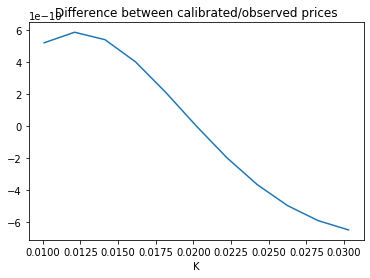

In [40]:
calib_b_bar = b_bar(maturities, bonds, maturity_grid, [0], [0], calib_param[0][0], calib_param[1][0], chi)
calib_lambda_bar = psi(T0,IV[0][5],calib_b_bar) # lambda bar = psi (b_bar) with ATM Implied vol.
print("Lambda_bar, b_bar = ",calib_lambda_bar,calib_b_bar)
d = [log_displaced(S0,A0,T0,strikes[m],calib_lambda_bar,calib_b_bar) - log_displaced(S0,A0,T0,strikes[m],l,b) for m in range(len(strikes))]
plt.plot(strikes,d)
plt.title("Difference between calibrated/observed prices")
plt.xlabel("K")
print("Absolute diff.",d)
plt.show()

Relative diff. in % [1.084264059051313e-06, 1.4534730539481777e-06, 1.6092304303364746e-06, 1.4524095136763246e-06, 9.245719430756051e-07, 1.651373455113398e-10, -1.3231304496611733e-06, -3.032662312519226e-06, -5.106943889337872e-06, -7.5198880013804285e-06, -1.024358056907724e-05]


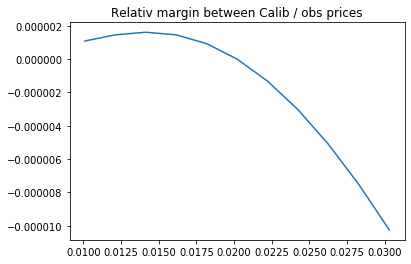

In [41]:
d2 = [100*d[m]/log_displaced(S0,A0,T0,strikes[m],l,b) for m in range(len(strikes))]
plt.plot(strikes,d2)
plt.title("Relativ margin between Calib / obs prices")
print("Relative diff. in %",d2)
plt.show()

### Calibration sur $\bar{\lambda},\bar{b}$

In [60]:
#Data
data = data_set_bis(maturity_grid,strikes,IV,chi,delta,[IV[0][5]])
print("(lambda_LD,b_LD) Observed:",data)

(lambda_LD,b_LD) Observed: [[0.5 0.9]]


In [61]:
# Calibration
calib_param = calib2(data,maturity_grid,delta,True)
print("(lambda_Pit.,b_Pit.)=",calib_param)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 61
         Function evaluations: 117
Exec. time: 396.5330698490143 sec
(lambda_Pit.,b_Pit.)= (array([3.6437048]), array([0.1391929]))


lambda_bar, b_bar = 0.4999952467575068 0.9000058993005275
Absolute diff. [-6.721210569354819e-08, -1.0076589281732273e-07, -1.309160102963558e-07, -1.5390739482867843e-07, -1.683269985272573e-07, -1.7448665853153633e-07, -1.7366762349035891e-07, -1.6752034962680407e-07, -1.576824114613018e-07, -1.4557947415963501e-07, -1.3235062998329106e-07]


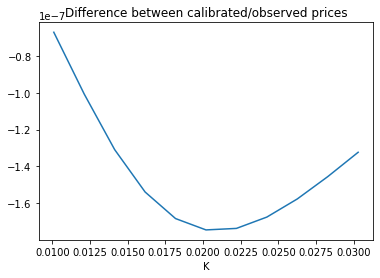

In [52]:
calib_b_bar = b_bar(maturities, bonds, maturity_grid, [0], [0], calib_param[0][0], calib_param[1][0], chi)
calib_lambda_bar = lambda_bar(maturities, bonds, maturity_grid,[0], [0], calib_param[0][0], calib_param[1][0], chi)
print("lambda_bar, b_bar =",calib_lambda_bar,calib_b_bar)
d = [log_displaced(S0,A0,T0,strikes[m],calib_lambda_bar,calib_b_bar) - log_displaced(S0,A0,T0,strikes[m],l,b)  for m in range(len(strikes))]
plt.plot(strikes,d)
plt.title("Difference between calibrated/observed prices")
plt.xlabel("K")
print("Absolute diff.",d)
plt.show()

Relative diff. in % [-0.0001397490081111399, -0.0002493038426507031, -0.0003896034164367367, -0.0005558001456215761, -0.0007427426421636232, -0.0009457009839301354, -0.0011606334286562577, -0.0013842199857840058, -0.001613795500588219, -0.0018472501888277873, -0.0020829288224559327]


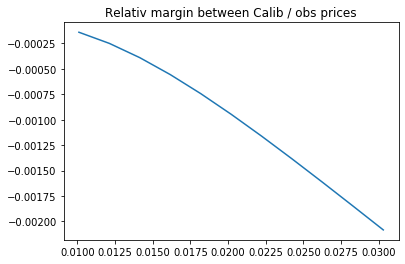

In [53]:
d2 = [100*d[m]/log_displaced(S0,A0,T0,strikes[m],l,b) for m in range(len(strikes))]
plt.plot(strikes,d2)
plt.title("Relativ margin between Calib / obs prices")
print("Relative diff. in %",d2)
plt.show()

IV diff.  [-6.35571723e-06 -5.89495812e-06 -5.54160124e-06 -5.26050144e-06
 -5.03057890e-06 -4.83835947e-06 -4.67480277e-06 -4.53360826e-06
 -4.41022848e-06 -4.30129376e-06 -4.20425749e-06]


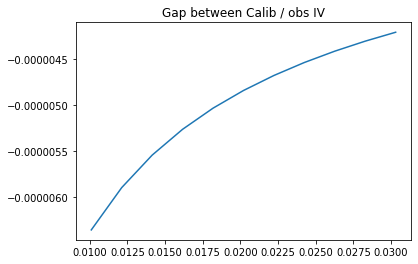

In [54]:
d_vol = np.array([biss_python(log_displaced(S0,A0,T0,strikes[m],calib_lambda_bar,calib_b_bar), bonds, strikes[m], maturities) for m in range(len(strikes))]) - np.array(IV[0])
plt.plot(strikes,d_vol)
plt.title("Gap between Calib / obs IV")
print("IV diff. ",d_vol)
plt.show()

### Dim. 2

In [92]:
# Sanitary test on displaced log normal prices with 2 maturities 1Y, 2Y 
l = [0.5,0.5]
b = [0.5,0.9]

maturity_grid = [0,1,2,6]
term_date = maturity_grid[-1]
delta = 1
IV = np.zeros((len(maturity_grid)-2,11))

#DATA

for i in range(1,len(maturity_grid)-1):
    T0 = maturity_grid[i]
    maturities = np.arange(T0,term_date + delta,delta)
    bonds = [np.exp(-r*m) for m in maturities]
    S0 = S(0,0,0,maturities,bonds,1,chi)
    A0 = A(0,0,0,maturities,bonds,1,chi)
    strikes = [0.1*k*S0 for k in range(5,16)] # 50% to 150% of the strike ATM
    IV[i-1] = [biss_python(log_displaced(S0,A0,T0,strikes[m],l[i-1],b[i-1]), bonds, strikes[m], maturities) for m in range(len(strikes))]

data = data_set_bis(maturity_grid,strikes,IV,chi,delta,IV[:,5])
print("b_obs=",data)

b_obs= [[0.5        0.5       ]
 [0.5        0.90000001]]


In [93]:
# Calibration
calib_param = calib2(data,maturity_grid,delta)
print("(lambda_Pit.,b_Pit.)=",calib_param)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 56
         Function evaluations: 109
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 56
         Function evaluations: 105
(lambda_Pit.,b_Pit.)= (array([3.63510878, 3.9463528 ]), array([0.0719562 , 0.16983547]))


In [94]:
maturities1 = np.arange(maturity_grid[1],term_date + delta,delta)
bonds1 = [np.exp(-r*m) for m in maturities1]
maturities2 = np.arange(maturity_grid[2],term_date + delta,delta)
bonds2 = [np.exp(-r*m) for m in maturities2]

calib_b_bar1 = b_bar(maturities1, bonds1, maturity_grid, [0], [0], calib_param[0][0], calib_param[1][0], chi)
calib_lambda_bar1 = lambda_bar(maturities1, bonds1, maturity_grid,[0], [0], calib_param[0][0], calib_param[1][0], chi)
calib_b_bar2 = b_bar(maturities2, bonds2, maturity_grid, [calib_param[0][0]], [calib_param[1][0]], calib_param[0][1], calib_param[1][1], chi)
calib_lambda_bar2 = lambda_bar(maturities2, bonds2, maturity_grid,[calib_param[0][0]], [calib_param[1][0]], calib_param[0][1], calib_param[1][1], chi)
print("lambda_bar1, b_bar1 =",calib_lambda_bar1,calib_b_bar1)
print("lambda_bar2, b_bar2 =",calib_lambda_bar2,calib_b_bar2)

lambda_bar1, b_bar1 = 0.5000011840432909 0.49999832375392156
lambda_bar2, b_bar2 = 0.49999903689023484 0.8999946753683894


## Test sanitaire sur des prix Monte Carlo

### Calibration sur $\bar{b}$

In [42]:
lambda_Cheyette = 0.2
b_Cheyette = 0.5

N,M = 250,100000
maturity_grid = [0,1,6]
T0 = 1
term_date = 6
delta = 1
maturities = np.arange(T0,term_date + delta,delta)
bonds = [np.exp(-r*m) for m in maturities]
S0 = S(0,0,0,maturities,bonds,1,chi)
A0 = A(0,0,0,maturities,bonds,1,chi)
strikes = [0.1*k*S0 for k in range(5,16)] # 50% to 150% of the strike ATM

# Data
sim = simul(lambda_Cheyette,S0,b_Cheyette,chi,T0,N,M,scheme = "Euler")
Prices = [swaption_MC(M,sim,k,chi,bonds,maturities) for k in strikes]
IV = [[biss_python(Prices[m], bonds, strikes[m], maturities) for m in range(len(strikes))]]

In [43]:
data = data_b(maturity_grid,strikes,IV,chi,delta,IV[0][5])
print("b_obs=",data)

b_obs= [[0.02744745]]


In [44]:
# Calibration
calib_param = calib3(data, maturity_grid, delta)
print("(lambda_Pit.,b_Pit.)=",calib_param)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 62
         Function evaluations: 113
(lambda_Pit.,b_Pit.)= (array([1.22806827]), array([-0.00801596]))


lambda_bar, b_bar = 0.027446863014474906 0.027447447571818155
Absolute diff. [-7.84900120481824e-07, -8.336558718416431e-07, -8.82411621615925e-07, -9.311673708697898e-07, -8.994723640267516e-07, 3.421980580842199e-14, -5.039203601514708e-07, 6.272674914727758e-17, 1.5708144212682237e-31, 1.1598839518616042e-51, 2.5551985372957997e-77]


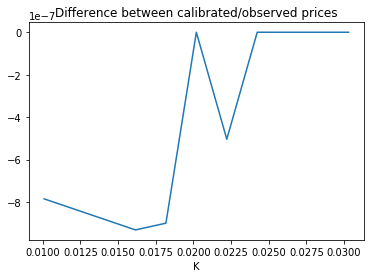

In [47]:
calib_b_bar = b_bar(maturities, bonds, maturity_grid, [0], [0], calib_param[0][0], calib_param[1][0], chi)
calib_lambda_bar = psi(T0,IV[0][5],calib_b_bar)
print("lambda_bar, b_bar =",calib_lambda_bar,calib_b_bar)
d = [log_displaced(S0,A0,T0,strikes[m],calib_lambda_bar,calib_b_bar) - Prices[m]  for m in range(len(strikes))]
plt.plot(strikes,d)
plt.title("Difference between calibrated/observed prices")
plt.xlabel("K")
print("Absolute diff.",d)
plt.show()

Relative diff. in % [-0.00168289397428964, -0.0022342758508011517, -0.0031532321271304014, -0.004991094007960319, -0.0096418817665615, 3.350382897755141e-09, -85.46435664421, inf, inf, inf, inf]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  """Entry point for launching an IPython kernel.


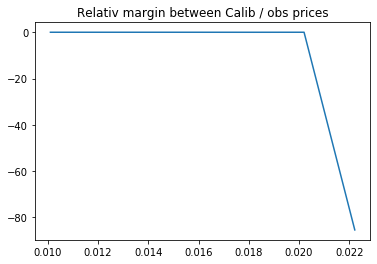

In [48]:
d2 = [100*d[m]/Prices[m] for m in range(len(strikes))]
plt.plot(strikes,d2)
plt.title("Relativ margin between Calib / obs prices")
print("Relative diff. in %",d2)
plt.show()

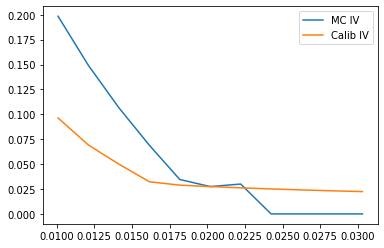

In [50]:
IV_calib = [biss_python(log_displaced(S0,A0,T0,strikes[m],calib_lambda_bar,calib_b_bar), bonds, strikes[m], maturities) for m in range(len(strikes))]
plt.plot(strikes,IV[0],label='MC IV')
plt.plot(strikes, IV_calib,label='Calib IV')
plt.legend()
plt.show()

Avec des données d'entrée générés par la méthode Monte Carlo, la calibration assure que les courbes de volatilité implicite sont proches autour de la monnaie mais pas nécessairement ITM ou OTM.

### Calibration sur $\bar{\lambda},\bar{b}$

In [44]:
data = data_set_bis(maturity_grid,strikes,IV,chi,delta,[IV[0][5]])
print("lambda_LD_obs, b_LD_obs =",data)

lambda_LD_obs, b_LD_obs = [[0.02692019 1.        ]]


In [34]:
# Calibration
calib_param = calib2(data,maturity_grid,delta)
print("(lambda_Pit.,b_Pit.)=",calib_param)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 53
         Function evaluations: 104
(lambda_Pit.,b_Pit.)= (array([0.19614808]), array([0.15862879]))


lambda_bar, b_bar = 0.0272781728632771 0.9999950450544318
Absolute diff. [1.2175146464780962e-05, 1.2355079453851836e-05, 1.253501244405375e-05, 1.2714945434040559e-05, 1.292633612394109e-05, -2.8790785549896725e-09, -3.2217851569039173e-07, 4.658172244848645e-15, 9.904075947103164e-26, 7.082588083121533e-39, 5.85602272555823e-54]


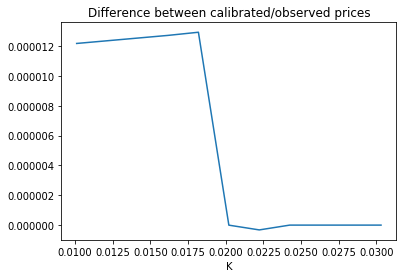

In [36]:
calib_b_bar = b_bar(maturities, bonds, maturity_grid, [0], [0], calib_param[0][0], calib_param[1][0], chi)
calib_lambda_bar = lambda_bar(maturities, bonds, maturity_grid,[0], [0], calib_param[0][0], calib_param[1][0], chi)
print("lambda_bar, b_bar =",calib_lambda_bar,calib_b_bar)
d = [log_displaced(S0,A0,T0,strikes[m],calib_lambda_bar,calib_b_bar) - Prices[m]  for m in range(len(strikes))]
plt.plot(strikes,d)
plt.title("Difference between calibrated/observed prices")
plt.xlabel("K")
print("Absolute diff.",d)
plt.show()

Relative diff. in % [0.02611182643058588, 0.03312447914283062, 0.04481441900976024, 0.06820249722520116, 0.13877010150578262, -0.00028363516739905996, -66.843217953877, inf, inf, inf, inf]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  """Entry point for launching an IPython kernel.


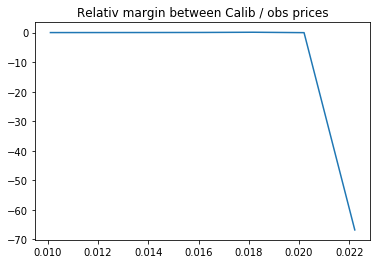

In [38]:
d2 = [100*d[m]/Prices[m] for m in range(len(strikes))]
plt.plot(strikes,d2)
plt.title("Relativ margin between Calib / obs prices")
print("Relative diff. in %",d2)
plt.show()

In [ ]:
IV_calib = [biss_python(log_displaced(S0,A0,T0,strikes[m],calib_lambda_bar,calib_b_bar), bonds, strikes[m], maturities) for m in range(len(strikes))]
plt.plot(strikes,IV[0],label='MC IV')
plt.plot(strikes, IV_calib,label='Calib IV')
plt.legend()
plt.show()

( Erreur pour les strikes car les derniers prix MC sont évalués à 0 )

**Remarque:** L'algorithme de calibration utilisé a pour objectif de reproduire les prix observés grâce à la formule de pricing par approximation displaced log normale. Il n'est donc pas adapté à la reproduction des prix avec la méthode de Monte Carlo.

---
### Tests bilatéraux

In [68]:
def test(l,b):
    print("Test for (l,b)=",l,b)
    N,M = 250,10000
    maturity_grid = [0,1,6]
    T0 = 1
    term_date = 6
    delta = 1
    maturities = np.arange(T0,term_date + delta,delta)
    bonds = [np.exp(-r*m) for m in maturities]
    S0 = S(0,0,0,maturities,bonds,1,chi)
    A0 = A(0,0,0,maturities,bonds,1,chi)
    strikes = [0.1*k*S0 for k in range(5,16)] # 50% to 150% of the strike ATM

    #IV Monte Carlo
    calib_param = calib2([[l,b]],maturity_grid,delta)
    lambda_Chey, b_Chey = calib_param[0][0], calib_param[1][0]
    print("lambda_Chey, b_Chey =",lambda_Chey,b_Chey)
    
    sim = simul(lambda_Chey,S0,b_Chey,chi,T0,N,M,scheme = "Euler")
    Prices = [swaption_MC(M,sim,k,chi,bonds,maturities) for k in strikes]
    IV = [[biss_python(Prices[m], bonds, strikes[m], maturities) for m in range(len(strikes))]]
    
    #IV log_displaced (l,b)
    prix = [log_displaced(S0,A0,T0,strikes[m],l,b)  for m in range(len(strikes))]
    IV2 = [biss_python(prix[m], bonds, strikes[m], maturities) for m in range(len(strikes))]
    
    diff = np.array(IV[0]) - np.array(IV2)
    
    # Fitted log displaced curve
    data = data_set_bis(maturity_grid,strikes,IV,chi,delta,[IV[0][5]])
    print("Param_LD = ",data)
    
    prix_LD = [log_displaced(S0,A0,T0,strikes[m],data[0][0],data[0][1])  for m in range(len(strikes))]
    IV_LD = [biss_python(prix_LD[m], bonds, strikes[m], maturities) for m in range(len(strikes))]
    
    # Plot IV curves
    plt.plot(strikes,IV_LD,label='Log-displaced')
    plt.plot(strikes,IV[0],label='MC')
    plt.plot(strikes,IV2,label='LD (' + str(l) + ',' + str(b) + ')')
    plt.xlabel("K")
    plt.legend()
    plt.show()
    
    #print diff ATM
    print("Diff ATM (MC - Log-displaced)",IV[0][5] - IV_LD[5])
    print("Diff ATM (MC - LD(l,b)) =",diff[5])

Test for (l,b)= 0.5 0.5
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 56
         Function evaluations: 108
lambda_Chey, b_Chey = 3.643591522457923 0.07171652184471368
Param_LD =  [[0.49146823 0.64391239]]


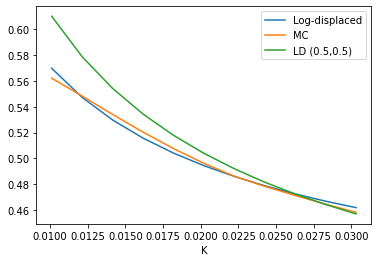

Diff ATM (MC - Log-displaced) 0.0017764032259037776
Diff ATM (MC - LD(l,b)) = -0.007792970932314347


In [69]:
test(0.5,0.5)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 56
         Function evaluations: 108
lambda_Chey, b_Chey = 3.643591522457923 0.07171652184471368
Param_LD =  [[0.49589132 0.51968725]]


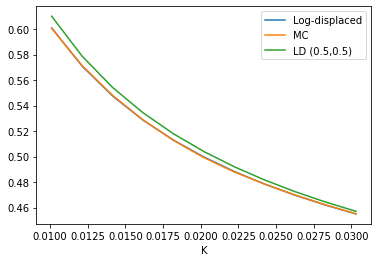

Diff ATM (MC - Log-displaced) -0.0004562022991194681
Diff ATM (MC - LD(l,b)) = -0.00476830993193289


In [121]:
test(0.5,0.5)

Test for (l,b)= 0.5 0.9
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 61
         Function evaluations: 117
lambda_Chey, b_Chey = 3.6437048045927316 0.13919290092682696
Param_LD =  [[0.49689892 0.86813022]]


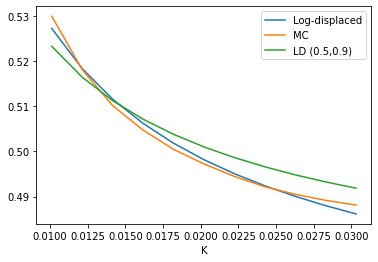

Diff ATM (MC - Log-displaced) -0.0009526255553282681
Diff ATM (MC - LD(l,b)) = -0.0037795725415890047
Test for (l,b)= 0.1 0.8
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 57
         Function evaluations: 110
lambda_Chey, b_Chey = 0.7213335485212217 0.123858984615148
Param_LD =  [[0.06441016 2.16498038]]


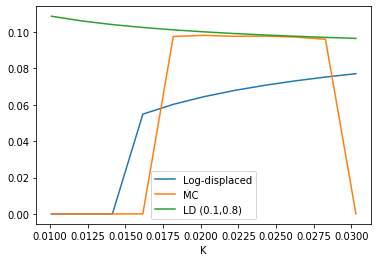

Diff ATM (MC - Log-displaced) 0.03371273234961336
Diff ATM (MC - LD(l,b)) = -0.0019331531052557693


In [57]:
test(0.5,0.9)
test(0.1,0.8)

Test for (l,b)= 0.1 0.9
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 58
         Function evaluations: 109
lambda_Chey, b_Chey = 0.7204227483264469 0.14116909350743265
Param_LD =  [[0.08139695 0.99992313]]


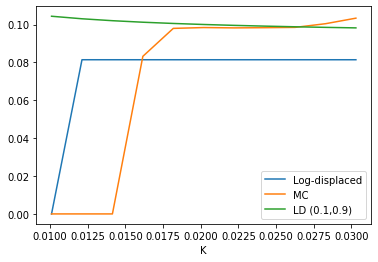

Diff ATM (MC - Log-displaced) 0.016994525183235965
Diff ATM (MC - LD(l,b)) = -0.0016164443854904675


In [65]:
test(0.1,0.9)

Test for (l,b)= 0.7 0.9
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 67
         Function evaluations: 129
lambda_Chey, b_Chey = 5.1621969796846425 0.137179837338138
Param_LD =  [[0.69382845 0.90537715]]


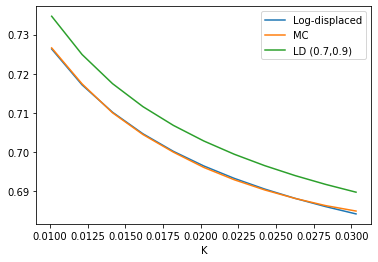

Diff ATM (MC - Log-displaced) -0.00037940081710985396
Diff ATM (MC - LD(l,b)) = -0.00676495102879926


In [143]:
test(0.7,0.9)

**Tests pour des 'faibles' valeurs de b et de 'fortes' valeurs de lambda**

Test for (l,b)= 0.5 0.2
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 60
         Function evaluations: 112
lambda_Chey, b_Chey = 3.64350590080361 0.021097605181106163
Param_LD =  [[0.50026056 0.2079516 ]]


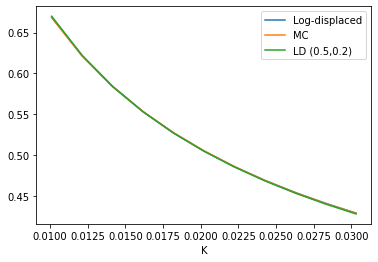

Diff ATM (MC - Log-displaced) 0.00029031976282567484
Diff ATM (MC - LD(l,b)) = 0.0005415346458903514


In [144]:
test(0.5,0.2)

Test for (l,b)= 0.8 0.1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 57
         Function evaluations: 112
lambda_Chey, b_Chey = 5.836365772370925 0.004204139563973267
Param_LD =  [[0.79549346 0.1062539 ]]


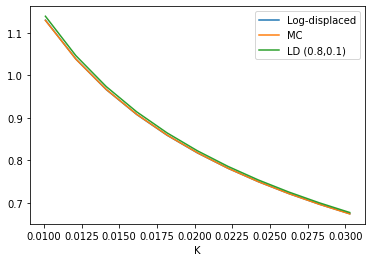

Diff ATM (MC - Log-displaced) 0.00028306211561357486
Diff ATM (MC - LD(l,b)) = -0.004644059717975324


In [58]:
test(0.8,0.1)

**'Fortes' valeurs pour lambda et b**

Test for (l,b)= 0.9 0.9
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 62
         Function evaluations: 120
lambda_Chey, b_Chey = 6.746789779723514 0.13444224793926435
Param_LD =  [[0.88743569 0.8684901 ]]


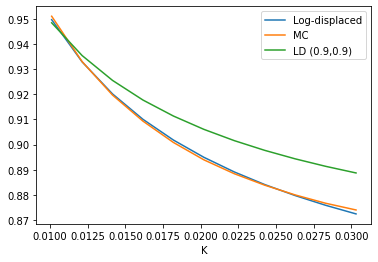

Diff ATM (MC - Log-displaced) -0.0010035895252258342
Diff ATM (MC - LD(l,b)) = -0.012112876950141072


In [66]:
test(0.9,0.9)

**'faibles' valeurs pour lambda et b**

Test for (l,b)= 0.1 0.1
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 49
         Function evaluations: 96
lambda_Chey, b_Chey = 0.728227242867401 0.004231859564249929
Param_LD =  [[0.09324725 0.99384294]]


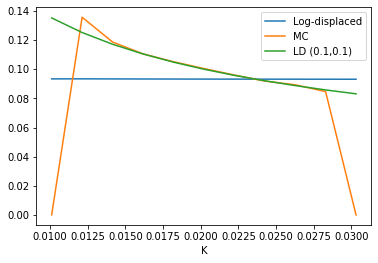

Diff ATM (MC - Log-displaced) 0.007248230797358701
Diff ATM (MC - LD(l,b)) = 0.0004546083414425084


In [67]:
test(0.1,0.1)

### Intervalles de confiance pour l'estimateur Monte Carlo

On va donner l'écart maximum en valeur absolue entre l'estimateur et la vraie valeur avec un seuil de confiance 95%.

L'intervalle de confiance est de: 
$$\big[ \bar{X}_n - \Phi^{-1}(1-\frac{\alpha}{2}) \sqrt{\frac{\hat{\sigma}_n^2}{n}} \ ; \ \bar{X}_n + \Phi^{-1}(1-\frac{\alpha}{2}) \sqrt{\frac{\hat{\sigma}_n^2}{n}} \big]$$

On va afficher le rayon de l'intervalle pour différents nombres de simulations

In [39]:
# Confiance interval of the Monte Carlo estimator
for m in [100,1000,10000,100000]:
    print("M = ",m)
    sim = simul(lambda_Chey,S0,b_Chey,chi,T0,N,m,scheme = "Euler")
    print(swaption_MC(m,sim,S0,chi,bonds,maturities,True,True))
    print()

M =  100
Variance: 0.0008470598997682892
IC (95%) radius: 0.005704441524768099
0.02184016288254669

M =  1000
Variance: 0.0008027940084391629
IC (95%) radius: 0.0017561359465656091
0.01756460723493873

M =  10000
Variance: 0.000814349593207383
IC (95%) radius: 0.0005593214994317206
0.018027217535651757

M =  100000
Variance: 0.0008311953709711043
IC (95%) radius: 0.00017869303671723177
0.01828180366592548

